In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import beamline34IDC
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna
import botorch

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

25030


In [5]:
!pwd

/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test


In [6]:
base_dir = Path('/'.join(beamline34IDC.__file__.split('/')[:-2]))
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [7]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors_ranges = {'hkb_1': [-50, 50], 
                      'vkb_1': [-50, 50],
                      'hkb_2': [-50, 50],
                      'vkb_2': [-50, 50],
                      'hkb_3': [-0.04, 0.04],
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], 
                      'vkb_4': [-30, 30]}

In [11]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


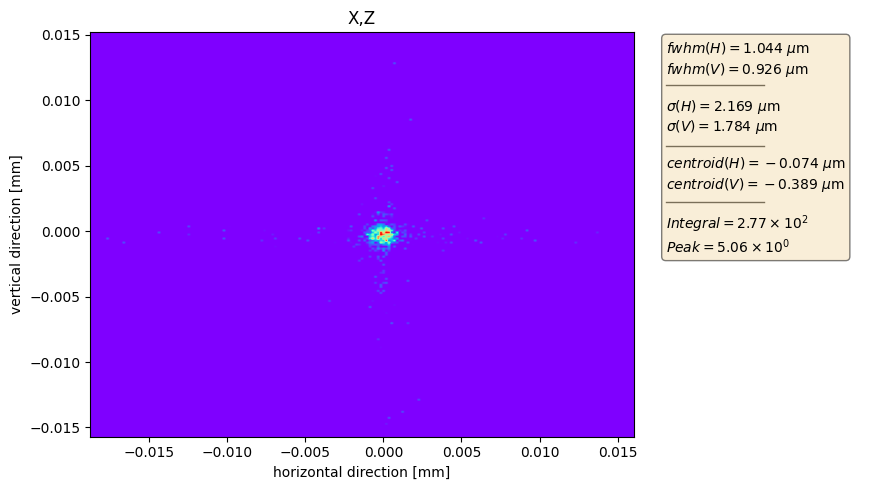

In [12]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

In [13]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [14]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [15]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [169]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    #def motor_subset_loss_function(self, motor_types: list, verbose: bool = True):
    #    lossfn_object_this = self.TrialInstanceLossFunction(self, verbose=verbose)
    #    
    #    translations_all = np.zeros(len(self.motor_types))
    #    
    #    def closure_fn(translations):
    #        for ix, motor in enumerate(motor_types):
    #            iy = self.motor_types.index(motor)
    #            translations_all[iy] = translations[ix]
    #        
    #        return lossfn_object_this.loss(translations_all)
    #    return closure_fn
    
    def set_optimizer_options(self, motor_ranges: list=None, 
                              base_sampler: optuna.samplers.BaseSampler = None, 
                              directions: str = None, 
                              integral_threshold: float = 1e2,
                              **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            #if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            #else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4
            
            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    #return [1e4] * len(self._loss_function_list)
                    raise optuna.TrialPruned
            
            for k in ['sigma', 'fwhm']:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0: loss[width_idx] = 1e4
            loss = list(loss)
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    #def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


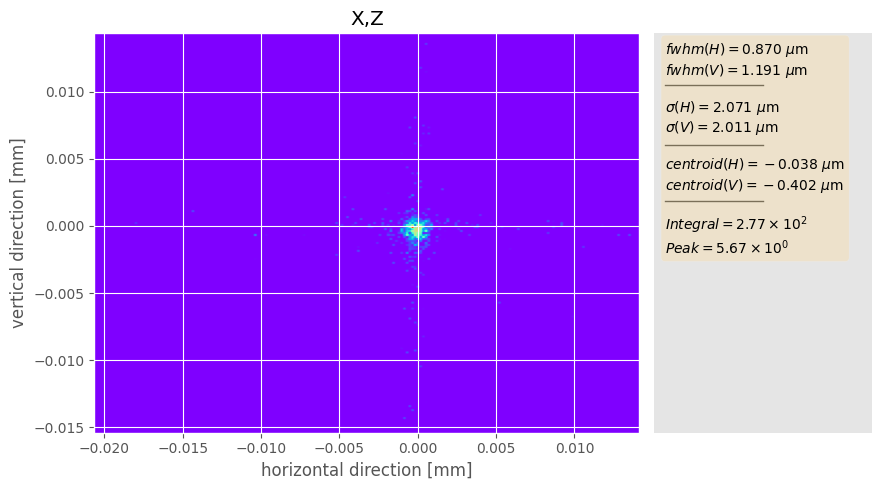

In [130]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system)
plot_shadow_beam_spatial_distribution(beam)

In [134]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0004074400204964938, 0.0028869912177309563)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir

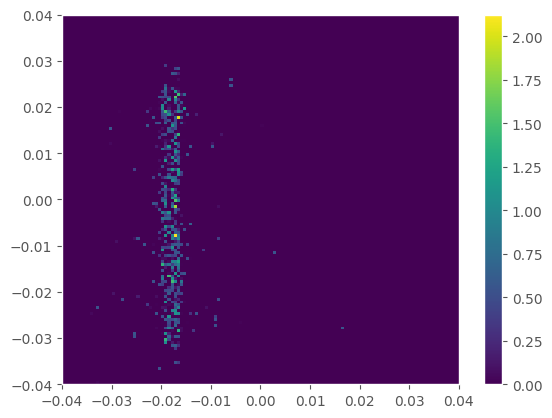

In [135]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], 
                                                                               integral_threshold=100,
                                                                               nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [136]:
hist.data_2D.sum()

220.76184300073092

In [170]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

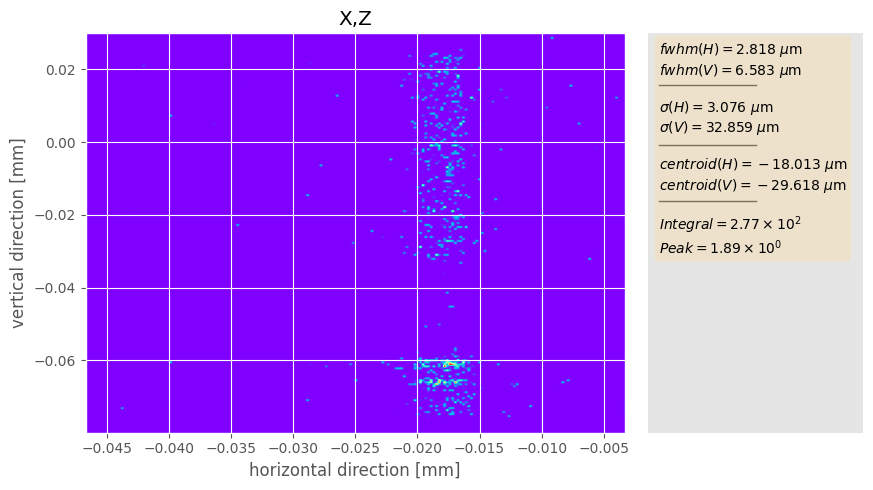

In [171]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [172]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [173]:
base_sampler = optuna.integration.BoTorchSampler()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/3702032374.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler()


In [174]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler)

[I 2022-09-24 18:29:45,296] A new study created in memory with name: no-name-448c59c8-b12b-4bc2-aea9-a4a3ddbb179e


In [175]:
opt_trial.trials(200, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/3358725788.py:80: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

In [176]:
opt_trial.study.best_trials

[FrozenTrial(number=48, values=[0.0029569933446782163, 0.0030129014170700613], datetime_start=datetime.datetime(2022, 9, 24, 18, 31, 4, 12388), datetime_complete=datetime.datetime(2022, 9, 24, 18, 31, 6, 192087), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.017595865315812878, 'hkb_4': -14.7, 'vkb_4': 21.300000000000004}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


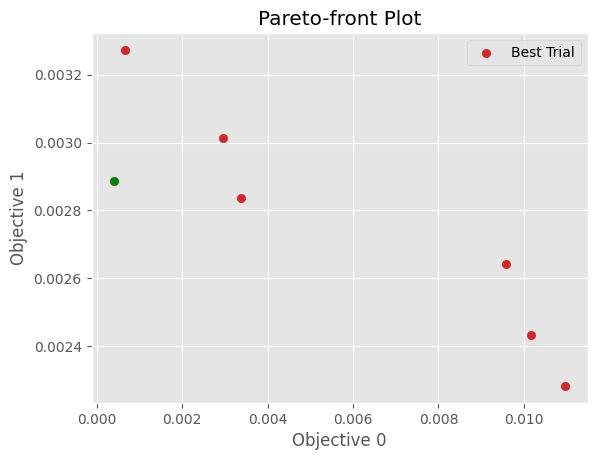

In [177]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [178]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-11.628434027377699
-11.556123073131896
-10.607790178731527
-10.595411199223445
-13.038677959223634
-10.584095173762124


[0.0029569933446782163, 0.0030129014170700613]


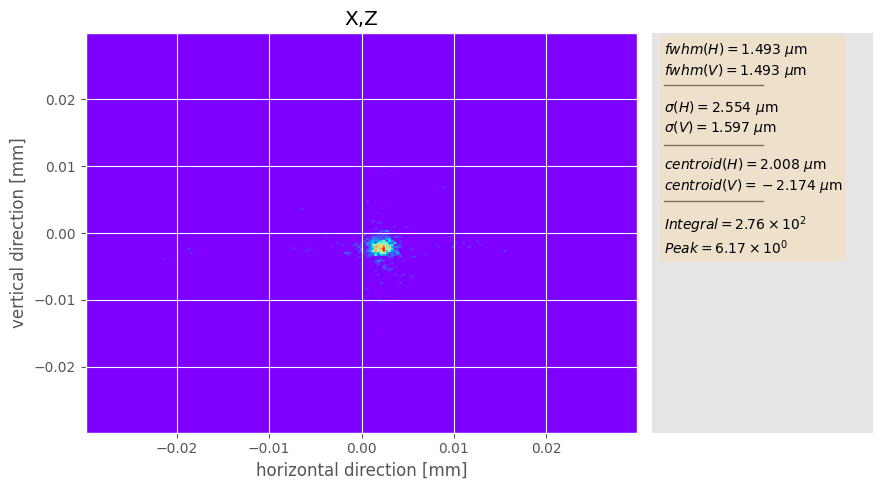

[0.0033760459978155323, 0.0028368159624584314]


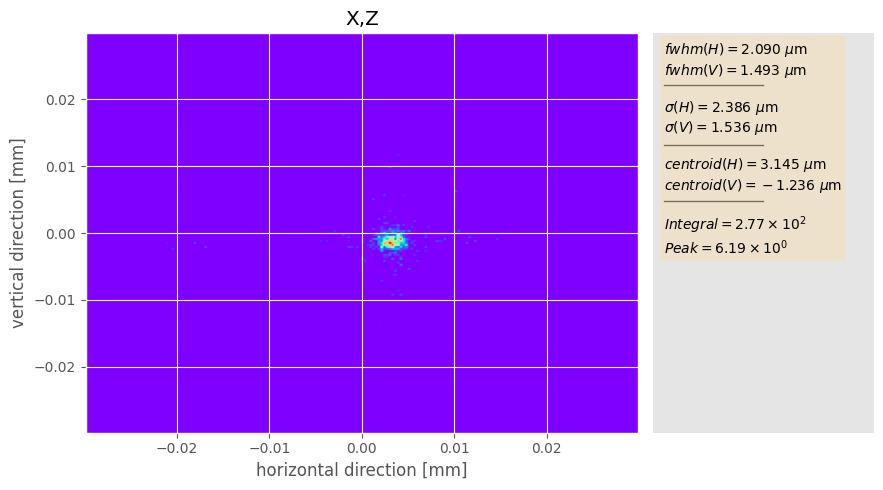

[0.01016280282039046, 0.002432661941537903]


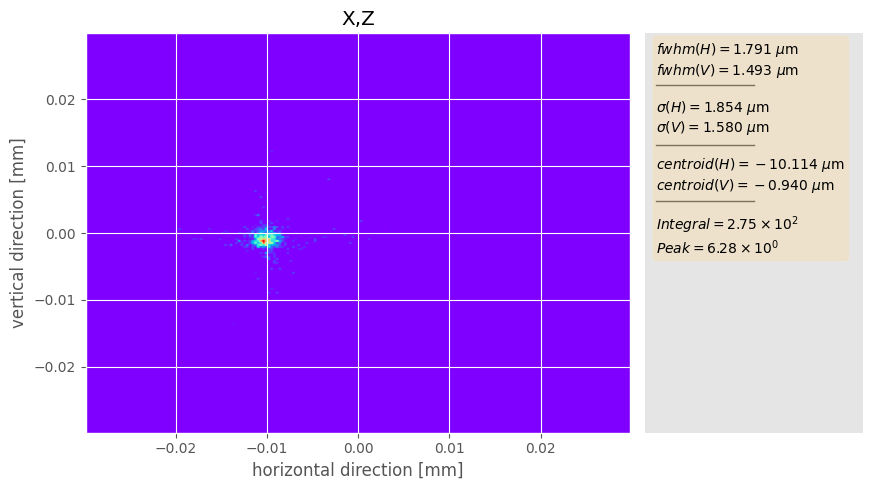

[0.010964054681503677, 0.002282969922579443]


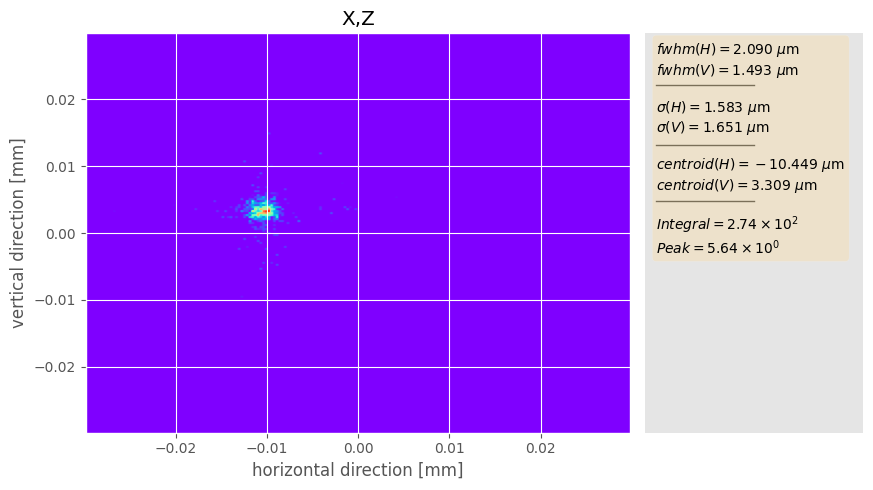

[0.0006644085732878124, 0.003272946325672579]


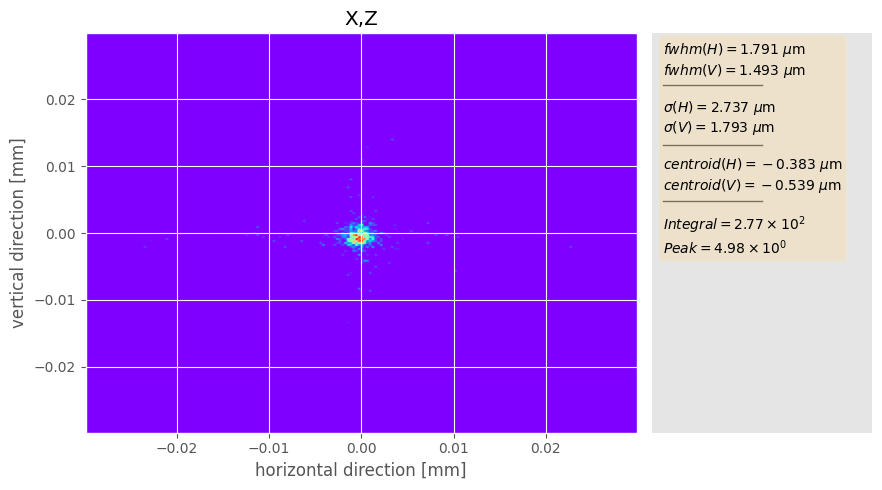

[0.009579393546821023, 0.002642699937925913]


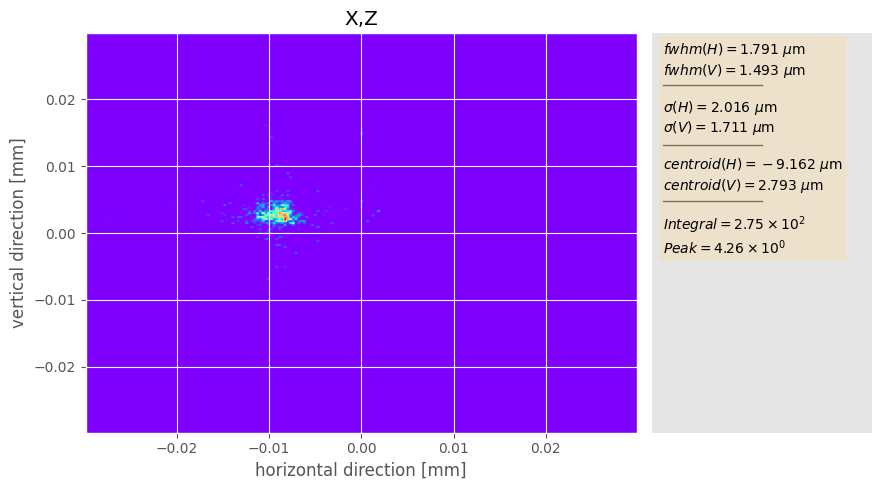

In [179]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [180]:
opt_trial._objective(opt_trial.study.best_trials[4])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


[0.000664500132637207, 0.003272853867092505]

In [181]:
opt_trial.study.enqueue_trial(opt_trial.study.best_trials[4].params)

In [182]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
[

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:10,579] Trial 201 finished with values: [0.008803786771403874, 0.0033385277024972283] and parameters: {'hkb_1': -3.9189000000000007, 'vkb_1': -2.2076000000000064, 'hkb_2': 6.3333999999999975, 'vkb_2': 26.796699999999987, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.0016027564561247529, 'hkb_4': -16.299999999999997, 'vkb_4': 29.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:15,325] Trial 202 finished with values: [0.006807620498479198, 0.003351601795525468] and parameters: {'hkb_1': -10.395100000000006, 'vkb_1': 13.141299999999994, 'hkb_2': -1.3325000000000031, 'vkb_2': 27.2166, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.010329402716096399, 'hkb_4': -16.6, 'vkb_4': 29.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:19,146] Trial 203 finished with values: [0.00493170342050574, 0.0031025856744804027] and parameters: {'hkb_1': -13.756400000000006, 'vkb_1': 10.983899999999991, 'hkb_2': -29.7632, 'vkb_2': -0.868700000000004, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.014105206811824214, 'hkb_4': -7.799999999999997, 'vkb_4': 22.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:23,972] Trial 204 finished with values: [0.00036178996484107753, 0.003158802446357049] and parameters: {'hkb_1': -8.218600000000002, 'vkb_1': 4.183199999999992, 'hkb_2': -16.066500000000005, 'vkb_2': 12.491499999999995, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.010614548307835557, 'hkb_4': -14.1, 'vkb_4': 26.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:27,273] Trial 205 finished with values: [0.004995986643044463, 0.0034268145036724473] and parameters: {'hkb_1': -5.645300000000006, 'vkb_1': 24.9559, 'hkb_2': -42.097, 'vkb_2': -8.2376, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.0001425727958695791, 'hkb_4': -9.799999999999997, 'vkb_4': 27.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:31,090] Trial 206 finished with values: [0.0065495118473141555, 0.0029830446055559593] and parameters: {'hkb_1': -4.324900000000007, 'vkb_1': 19.07159999999999, 'hkb_2': -14.760400000000004, 'vkb_2': 23.346799999999988, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.014105206811824214, 'hkb_4': -7.699999999999999, 'vkb_4': 25.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:35,614] Trial 207 finished with values: [0.011013942261394077, 0.0035505584776669287] and parameters: {'hkb_1': -39.6674, 'vkb_1': 18.773599999999988, 'hkb_2': -26.006400000000003, 'vkb_2': 5.639899999999997, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.00509341496011341, 'hkb_4': -13.0, 'vkb_4': 25.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:39,320] Trial 208 finished with values: [0.0012582442940081155, 0.0030020290024496007] and parameters: {'hkb_1': 15.567099999999996, 'vkb_1': 3.978999999999992, 'hkb_2': -30.253700000000002, 'vkb_2': -0.30050000000000665, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.014105206811824214, 'hkb_4': -13.399999999999999, 'vkb_4': 24.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:42,728] Trial 209 finished with values: [0.005847678401253423, 0.003039409735059727] and parameters: {'hkb_1': 34.99619999999999, 'vkb_1': 23.9426, 'hkb_2': -42.0017, 'vkb_2': 7.527999999999992, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.0001425727958695791, 'hkb_4': -13.5, 'vkb_4': 27.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:46,319] Trial 210 finished with values: [0.0070736233684928615, 0.003163828262584062] and parameters: {'hkb_1': -2.879100000000001, 'vkb_1': 35.89569999999999, 'hkb_2': -25.995500000000003, 'vkb_2': -29.8824, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.0245771823237902, 'hkb_4': -9.399999999999999, 'vkb_4': 28.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:50,508] Trial 211 finished with values: [0.006188434141405166, 0.003114247856645868] and parameters: {'hkb_1': 17.1147, 'vkb_1': 30.804199999999994, 'hkb_2': -39.7374, 'vkb_2': 8.210399999999993, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.008869219055841225, 'hkb_4': -4.699999999999999, 'vkb_4': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:54,237] Trial 212 finished with values: [0.00011887661182456844, 0.003424837549498244] and parameters: {'hkb_1': 17.31389999999999, 'vkb_1': 29.56349999999999, 'hkb_2': -10.6768, 'vkb_2': 1.8403999999999954, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.010614548307835557, 'hkb_4': -15.2, 'vkb_4': 27.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:42:57,919] Trial 213 finished with values: [0.008360975246043355, 0.00293976977870549] and parameters: {'hkb_1': 39.5025, 'vkb_1': 4.008499999999998, 'hkb_2': -12.710600000000007, 'vkb_2': 25.56949999999999, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.0001425727958695791, 'hkb_4': -12.899999999999999, 'vkb_4': 23.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:01,668] Trial 214 finished with values: [0.008275908436569232, 0.0031648781368817528] and parameters: {'hkb_1': 28.973799999999997, 'vkb_1': -15.063300000000005, 'hkb_2': -22.901400000000002, 'vkb_2': -34.3902, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.014105206811824214, 'hkb_4': -6.299999999999997, 'vkb_4': 22.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:05,009] Trial 215 finished with values: [0.007367301458461053, 0.002824254209268227] and parameters: {'hkb_1': 36.560599999999994, 'vkb_1': 15.6023, 'hkb_2': -13.022100000000002, 'vkb_2': 17.238, 'hkb_3': 0.03504915783575618, 'vkb_3': 0.017595865315812878, 'hkb_4': -3.3999999999999986, 'vkb_4': 29.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:08,870] Trial 216 finished with values: [0.006391986576936719, 0.0034942973295457353] and parameters: {'hkb_1': 17.20769999999999, 'vkb_1': -42.219500000000004, 'hkb_2': -33.0636, 'vkb_2': 17.313299999999998, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.0001425727958695791, 'hkb_4': -5.899999999999999, 'vkb_4': 28.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:12,413] Trial 217 finished with values: [0.009031485060802811, 0.003163333971403337] and parameters: {'hkb_1': 33.689899999999994, 'vkb_1': -17.688700000000004, 'hkb_2': -28.3638, 'vkb_2': -37.5086, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.010614548307835557, 'hkb_4': 0.40000000000000213, 'vkb_4': 26.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:16,722] Trial 218 finished with values: [0.0118542127442076, 0.0035589952525185496] and parameters: {'hkb_1': -47.0743, 'vkb_1': -20.968700000000002, 'hkb_2': -45.594300000000004, 'vkb_2': -9.559200000000004, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.02981317007977318, 'hkb_4': -9.099999999999998, 'vkb_4': 28.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:22,697] Trial 219 finished with values: [0.015856120860977273, 0.0031559301532708755] and parameters: {'hkb_1': -12.328700000000005, 'vkb_1': -23.6156, 'hkb_2': -19.8195, 'vkb_2': -43.4296, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.03504915783575618, 'hkb_4': -13.5, 'vkb_4': 25.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:27,109] Trial 220 finished with values: [0.00600428586278582, 0.003172304872629839] and parameters: {'hkb_1': 40.27489999999999, 'vkb_1': 5.700099999999992, 'hkb_2': -23.027600000000003, 'vkb_2': -28.613000000000003, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.019341194567807203, 'hkb_4': -15.6, 'vkb_4': 28.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:31,628] Trial 221 finished with values: [0.01024153318618841, 0.0032998146572882593] and parameters: {'hkb_1': 34.31909999999999, 'vkb_1': -22.948400000000003, 'hkb_2': -15.163400000000003, 'vkb_2': 36.681799999999996, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.003633231299858236, 'hkb_4': -11.599999999999998, 'vkb_4': 21.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:36,039] Trial 222 finished with values: [0.0065153557603543615, 0.002809074940766568] and parameters: {'hkb_1': 46.424199999999985, 'vkb_1': 6.253799999999998, 'hkb_2': -25.6522, 'vkb_2': -20.574, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.012359877559829889, 'hkb_4': -12.099999999999998, 'vkb_4': 21.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:39,260] Trial 223 finished with values: [0.010803394262865113, 0.002766837047426047] and parameters: {'hkb_1': 3.9861999999999966, 'vkb_1': 49.51089999999999, 'hkb_2': -46.0396, 'vkb_2': -33.7993, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.012359877559829889, 'hkb_4': 0.20000000000000284, 'vkb_4': 24.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:42,729] Trial 224 finished with values: [0.0070812408845573735, 0.003064469011949117] and parameters: {'hkb_1': 47.19919999999999, 'vkb_1': -21.070000000000004, 'hkb_2': 14.823699999999988, 'vkb_2': -25.793100000000003, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.017595865315812878, 'hkb_4': -6.699999999999999, 'vkb_4': 28.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:46,893] Trial 225 finished with values: [0.016439614112843226, 0.0029768070096584218] and parameters: {'hkb_1': -5.370200000000004, 'vkb_1': 32.09039999999999, 'hkb_2': -8.171500000000002, 'vkb_2': -42.7805, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.036794487087750495, 'hkb_4': -1.5999999999999979, 'vkb_4': 25.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:51,534] Trial 226 finished with values: [0.0022836565060253364, 0.004630212040746441] and parameters: {'hkb_1': 6.210699999999996, 'vkb_1': -11.818900000000006, 'hkb_2': -39.0415, 'vkb_2': 17.762899999999988, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.001887902047863911, 'hkb_4': -18.9, 'vkb_4': 27.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:43:55,292] Trial 227 finished with values: [0.015708315475307693, 0.002927507848906099] and parameters: {'hkb_1': 49.7803, 'vkb_1': 37.5496, 'hkb_2': -24.8578, 'vkb_2': 31.476299999999995, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.012359877559829889, 'hkb_4': 1.0, 'vkb_4': 23.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:00,536] Trial 228 finished with values: [0.018803978465352533, 0.0029722424163503335] and parameters: {'hkb_1': 39.33309999999999, 'vkb_1': 33.21029999999999, 'hkb_2': -14.839500000000001, 'vkb_2': 24.7808, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.019056048976068045, 'hkb_4': -7.0, 'vkb_4': 26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:06,352] Trial 229 finished with values: [0.011754468488149546, 0.004068264568476969] and parameters: {'hkb_1': -15.092500000000001, 'vkb_1': 47.003399999999985, 'hkb_2': 46.11909999999999, 'vkb_2': -42.722, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.00509341496011341, 'hkb_4': -17.799999999999997, 'vkb_4': 29.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:10,437] Trial 230 finished with values: [0.003911791638905128, 0.002849868292004559] and parameters: {'hkb_1': 38.85199999999999, 'vkb_1': 33.91489999999999, 'hkb_2': 43.49579999999999, 'vkb_2': 7.920399999999994, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.014105206811824214, 'hkb_4': -6.399999999999999, 'vkb_4': 24.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:13,852] Trial 231 finished with values: [0.00661129556685079, 0.003308096332649384] and parameters: {'hkb_1': 28.92049999999999, 'vkb_1': 32.73989999999999, 'hkb_2': -42.8701, 'vkb_2': -8.444000000000003, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.0071238898038469, 'hkb_4': -13.599999999999998, 'vkb_4': 22.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:17,899] Trial 232 finished with values: [0.0009754662329839829, 0.003033708589535224] and parameters: {'hkb_1': 48.73089999999999, 'vkb_1': -9.972900000000003, 'hkb_2': 44.7666, 'vkb_2': 25.67739999999999, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.012359877559829889, 'hkb_4': -8.0, 'vkb_4': 26.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:22,274] Trial 233 finished with values: [0.01593112235004699, 0.0023271533100547004] and parameters: {'hkb_1': 44.16999999999999, 'vkb_1': 31.96419999999999, 'hkb_2': 25.598499999999987, 'vkb_2': -37.5957, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.012359877559829889, 'hkb_4': -1.7999999999999972, 'vkb_4': 23.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:27,925] Trial 234 finished with values: [0.012861741632145372, 0.0029280140966320266] and parameters: {'hkb_1': -29.490000000000002, 'vkb_1': -9.814, 'hkb_2': 25.573899999999995, 'vkb_2': -27.0896, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.010614548307835557, 'hkb_4': -14.399999999999999, 'vkb_4': 28.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:34,285] Trial 235 finished with values: [0.013697536401245346, 0.003376943221897596] and parameters: {'hkb_1': 38.8677, 'vkb_1': 12.897699999999993, 'hkb_2': 40.71339999999999, 'vkb_2': 46.53729999999999, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.019056048976068045, 'hkb_4': -9.5, 'vkb_4': 29.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:39,902] Trial 236 finished with values: [0.01310092811854826, 0.0028325468672577214] and parameters: {'hkb_1': 2.3162999999999982, 'vkb_1': -27.4139, 'hkb_2': 24.514499999999998, 'vkb_2': -18.6169, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.017595865315812878, 'hkb_4': -13.0, 'vkb_4': 22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:43,726] Trial 237 finished with values: [0.009087263853478501, 0.002699988666444059] and parameters: {'hkb_1': 43.98889999999999, 'vkb_1': 20.551599999999993, 'hkb_2': 38.59939999999999, 'vkb_2': -8.028100000000002, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.014105206811824214, 'hkb_4': -2.299999999999997, 'vkb_4': 25.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:48,811] Trial 238 finished with values: [0.011562342969492151, 0.0023593551747126073] and parameters: {'hkb_1': 27.392599999999987, 'vkb_1': 16.467099999999988, 'hkb_2': -22.718700000000002, 'vkb_2': -5.263800000000003, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.014105206811824214, 'hkb_4': -11.8, 'vkb_4': 24.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:52,883] Trial 239 finished with values: [0.010017882295197055, 0.0026223810251095833] and parameters: {'hkb_1': 20.79589999999999, 'vkb_1': 38.14439999999999, 'hkb_2': 21.519599999999997, 'vkb_2': -30.1856, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.015850536063818546, 'hkb_4': -6.299999999999997, 'vkb_4': 22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:44:57,603] Trial 240 finished with values: [0.017843890468704753, 0.0024128503284259486] and parameters: {'hkb_1': 16.93159999999999, 'vkb_1': 35.103599999999986, 'hkb_2': -16.9249, 'vkb_2': -2.711200000000005, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.014105206811824214, 'hkb_4': -2.799999999999997, 'vkb_4': 23.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:03,277] Trial 241 finished with values: [0.01337290540513455, 0.0026470966419431057] and parameters: {'hkb_1': 14.598299999999995, 'vkb_1': 38.560599999999994, 'hkb_2': 28.879599999999996, 'vkb_2': 21.06989999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.012359877559829889, 'hkb_4': -12.599999999999998, 'vkb_4': 21.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:07,707] Trial 242 finished with values: [0.012182342491492078, 0.003210218716092438] and parameters: {'hkb_1': 41.80919999999999, 'vkb_1': 45.69799999999999, 'hkb_2': -43.7566, 'vkb_2': -1.6593000000000018, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.036794487087750495, 'hkb_4': -11.599999999999998, 'vkb_4': 27.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:13,803] Trial 243 finished with values: [0.019120165528014387, 0.002669034046689122] and parameters: {'hkb_1': 35.46709999999999, 'vkb_1': 39.3484, 'hkb_2': -32.9819, 'vkb_2': -16.201100000000004, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.036794487087750495, 'hkb_4': -7.299999999999997, 'vkb_4': 24.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:19,314] Trial 244 finished with values: [0.012715970470892343, 0.00250323433133903] and parameters: {'hkb_1': 39.896699999999996, 'vkb_1': 28.912999999999997, 'hkb_2': -10.526900000000005, 'vkb_2': -33.2311, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.022831853071795867, 'hkb_4': -10.5, 'vkb_4': 27.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:23,071] Trial 245 finished with values: [0.005451181512830393, 0.0025566808807582484] and parameters: {'hkb_1': 46.583899999999986, 'vkb_1': 34.8767, 'hkb_2': -3.6610000000000014, 'vkb_2': -21.130000000000003, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.010614548307835557, 'hkb_4': -13.7, 'vkb_4': 25.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:27,474] Trial 246 finished with values: [0.007581682680428769, 0.0030039969631715257] and parameters: {'hkb_1': 40.48819999999999, 'vkb_1': 17.340099999999993, 'hkb_2': 27.283299999999997, 'vkb_2': -28.689100000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.0071238898038469, 'hkb_4': -11.399999999999999, 'vkb_4': 24.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:31,452] Trial 247 finished with values: [0.003928604296024271, 0.0030113886171538656] and parameters: {'hkb_1': 46.68769999999999, 'vkb_1': 2.502199999999995, 'hkb_2': -14.742700000000006, 'vkb_2': -49.5096, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.019341194567807203, 'hkb_4': -10.0, 'vkb_4': 24.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:37,167] Trial 248 finished with values: [0.010398024931066771, 0.003383993332242327] and parameters: {'hkb_1': 12.883199999999995, 'vkb_1': -24.204700000000003, 'hkb_2': 36.36109999999999, 'vkb_2': 24.818399999999997, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.017595865315812878, 'hkb_4': -16.2, 'vkb_4': 26.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:42,739] Trial 249 finished with values: [0.018121906603791513, 0.002331003092550842] and parameters: {'hkb_1': 37.212199999999996, 'vkb_1': 44.78869999999999, 'hkb_2': 25.11309999999999, 'vkb_2': 1.8421999999999983, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.014105206811824214, 'hkb_4': -6.599999999999998, 'vkb_4': 22.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:47,900] Trial 250 finished with values: [0.009985162019223278, 0.00273726962410705] and parameters: {'hkb_1': 45.399799999999985, 'vkb_1': 24.87079999999999, 'hkb_2': 19.56309999999999, 'vkb_2': -9.071200000000005, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.03504915783575618, 'hkb_4': -8.2, 'vkb_4': 26.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:53,763] Trial 251 finished with values: [0.013600459582022065, 0.0034250085561404746] and parameters: {'hkb_1': -27.5968, 'vkb_1': -27.906200000000002, 'hkb_2': -48.0057, 'vkb_2': -44.4698, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.012359877559829889, 'hkb_4': -12.7, 'vkb_4': 29.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:45:58,794] Trial 252 finished with values: [0.01757319858236465, 0.0024346702186414603] and parameters: {'hkb_1': 38.57209999999999, 'vkb_1': 33.99279999999999, 'hkb_2': -11.657700000000006, 'vkb_2': -41.0859, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.005378560551852568, 'hkb_4': -1.5999999999999979, 'vkb_4': 25.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:03,247] Trial 253 finished with values: [0.017374619079955952, 0.0026994688634586032] and parameters: {'hkb_1': 2.373599999999996, 'vkb_1': 42.419099999999986, 'hkb_2': 22.263199999999998, 'vkb_2': -9.948800000000006, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.022831853071795867, 'hkb_4': 3.3000000000000043, 'vkb_4': 27.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:08,847] Trial 254 finished with values: [0.012208326860604654, 0.0027158832909083236] and parameters: {'hkb_1': 30.44149999999999, 'vkb_1': 40.76679999999999, 'hkb_2': 38.96369999999999, 'vkb_2': 28.991899999999987, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.008869219055841225, 'hkb_4': -4.899999999999999, 'vkb_4': 26.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:14,801] Trial 255 finished with values: [0.013263100897283437, 0.00232173931669872] and parameters: {'hkb_1': 29.93849999999999, 'vkb_1': 43.44139999999999, 'hkb_2': -4.219200000000001, 'vkb_2': -16.2768, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.019341194567807203, 'hkb_4': -10.899999999999999, 'vkb_4': 23.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:20,136] Trial 256 finished with values: [0.015314922199189326, 0.0025090343244490456] and parameters: {'hkb_1': 30.142999999999986, 'vkb_1': 29.318499999999986, 'hkb_2': 6.520499999999998, 'vkb_2': -25.8213, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.036794487087750495, 'hkb_4': -5.599999999999998, 'vkb_4': 25.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:25,310] Trial 257 finished with values: [0.016577744050713706, 0.0026222364001130967] and parameters: {'hkb_1': 1.713799999999992, 'vkb_1': 23.70899999999999, 'hkb_2': 6.269699999999993, 'vkb_2': -41.566900000000004, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.005378560551852568, 'hkb_4': -2.799999999999997, 'vkb_4': 26.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:29,539] Trial 258 finished with values: [0.005637189962384306, 0.003360802468378232] and parameters: {'hkb_1': 18.092799999999997, 'vkb_1': 39.901399999999995, 'hkb_2': 23.854, 'vkb_2': 41.598299999999995, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.010614548307835557, 'hkb_4': -10.599999999999998, 'vkb_4': 21.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:35,985] Trial 259 finished with values: [0.009126006588554936, 0.0029381817693473053] and parameters: {'hkb_1': 25.377599999999987, 'vkb_1': 21.1374, 'hkb_2': -25.2508, 'vkb_2': -42.0366, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.0245771823237902, 'hkb_4': -17.799999999999997, 'vkb_4': 27.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:41,412] Trial 260 finished with values: [0.013878246452693959, 0.0026694112185127517] and parameters: {'hkb_1': 49.24199999999999, 'vkb_1': 28.611599999999996, 'hkb_2': -48.6303, 'vkb_2': 26.8874, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.0071238898038469, 'hkb_4': -8.099999999999998, 'vkb_4': 27.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:46,843] Trial 261 finished with values: [0.011694583949317373, 0.00232056151208574] and parameters: {'hkb_1': -0.09600000000000364, 'vkb_1': 42.398799999999994, 'hkb_2': -8.618300000000005, 'vkb_2': -26.537000000000003, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.014105206811824214, 'hkb_4': -13.5, 'vkb_4': 20.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:52,672] Trial 262 finished with values: [0.014251648068760451, 0.002713942931276624] and parameters: {'hkb_1': 40.37459999999999, 'vkb_1': -18.778100000000002, 'hkb_2': 25.321699999999993, 'vkb_2': -8.315600000000003, 'hkb_3': -0.012074731968090727, 'vkb_3': 0.003633231299858236, 'hkb_4': -6.0, 'vkb_4': 27.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:46:57,598] Trial 263 finished with values: [0.009837201507740393, 0.002728889535465585] and parameters: {'hkb_1': -33.9953, 'vkb_1': 34.04979999999999, 'hkb_2': 49.695499999999996, 'vkb_2': -6.079800000000006, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.022831853071795867, 'hkb_4': -5.399999999999999, 'vkb_4': 24.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:02,035] Trial 264 finished with values: [0.013777203286237915, 0.0034352133580691324] and parameters: {'hkb_1': -46.4053, 'vkb_1': -15.892000000000003, 'hkb_2': 31.472099999999998, 'vkb_2': 36.86649999999999, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.017595865315812878, 'hkb_4': 2.200000000000003, 'vkb_4': 26.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:08,073] Trial 265 finished with values: [0.015512453556230264, 0.0031442522225414425] and parameters: {'hkb_1': -22.702700000000004, 'vkb_1': -19.244000000000003, 'hkb_2': -36.1095, 'vkb_2': -46.1721, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.014105206811824214, 'hkb_4': -10.399999999999999, 'vkb_4': 19.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:13,181] Trial 266 finished with values: [0.014957056221020398, 0.002750178126851214] and parameters: {'hkb_1': 11.845199999999991, 'vkb_1': 48.67739999999999, 'hkb_2': 31.301699999999997, 'vkb_2': 4.379599999999996, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.02981317007977318, 'hkb_4': -2.299999999999997, 'vkb_4': 25.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:20,094] Trial 267 finished with values: [0.02150193478933461, 0.0038160551872785282] and parameters: {'hkb_1': 37.06869999999999, 'vkb_1': 43.75489999999999, 'hkb_2': 43.17219999999999, 'vkb_2': -42.8986, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.013820061220085056, 'hkb_4': -9.7, 'vkb_4': 20.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:24,142] Trial 268 finished with values: [0.0005061390170021264, 0.002724455477804195] and parameters: {'hkb_1': 48.305499999999995, 'vkb_1': 43.4434, 'hkb_2': 7.994799999999998, 'vkb_2': 0.17309999999999803, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.017595865315812878, 'hkb_4': -10.799999999999997, 'vkb_4': 23.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:30,812] Trial 269 finished with values: [0.013028929030933976, 0.0024645065581527345] and parameters: {'hkb_1': 3.391999999999996, 'vkb_1': 48.453599999999994, 'hkb_2': -5.2557000000000045, 'vkb_2': -15.828400000000002, 'hkb_3': -0.04, 'vkb_3': 0.0245771823237902, 'hkb_4': -14.399999999999999, 'vkb_4': 25.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:36,682] Trial 270 finished with values: [0.016641754596606554, 0.003414880124917938] and parameters: {'hkb_1': 44.7003, 'vkb_1': -33.2734, 'hkb_2': -6.846700000000006, 'vkb_2': -24.6019, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.019056048976068045, 'hkb_4': -5.5, 'vkb_4': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:42,840] Trial 271 finished with values: [0.012247179802987583, 0.002514663606982221] and parameters: {'hkb_1': -7.530200000000001, 'vkb_1': 37.901099999999985, 'hkb_2': 14.3322, 'vkb_2': -31.2756, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.012359877559829889, 'hkb_4': -14.7, 'vkb_4': 24.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:48,078] Trial 272 finished with values: [0.014411906565163436, 0.0028802834260625997] and parameters: {'hkb_1': -35.9324, 'vkb_1': 34.21119999999999, 'hkb_2': 48.057199999999995, 'vkb_2': 5.949199999999998, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.033303828583761845, 'hkb_4': -6.299999999999997, 'vkb_4': 28.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:47:55,329] Trial 273 finished with values: [0.018293607311379235, 0.0032318367875642964] and parameters: {'hkb_1': 45.91449999999999, 'vkb_1': 45.60549999999999, 'hkb_2': -17.9217, 'vkb_2': -24.065600000000003, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.024292036732051034, 'hkb_4': -11.899999999999999, 'vkb_4': 29.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:00,978] Trial 274 finished with values: [0.014629551646939165, 0.0027412798205375963] and parameters: {'hkb_1': 43.14569999999999, 'vkb_1': 31.952699999999993, 'hkb_2': 47.32339999999999, 'vkb_2': -32.0726, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.02806784082777885, 'hkb_4': -1.0999999999999979, 'vkb_4': 28.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:07,022] Trial 275 finished with values: [0.013273135466589278, 0.003129033016990686] and parameters: {'hkb_1': -24.5483, 'vkb_1': 45.5166, 'hkb_2': 23.578699999999998, 'vkb_2': -25.570800000000002, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.021086523819801535, 'hkb_4': -10.099999999999998, 'vkb_4': 20.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:13,312] Trial 276 finished with values: [0.01627271095072731, 0.0024675960411260564] and parameters: {'hkb_1': 49.17099999999999, 'vkb_1': 30.88069999999999, 'hkb_2': -21.2965, 'vkb_2': -33.8528, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.005378560551852568, 'hkb_4': -9.099999999999998, 'vkb_4': 29.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:19,916] Trial 277 finished with values: [0.020171116563379967, 0.002512509809421632] and parameters: {'hkb_1': 23.31309999999999, 'vkb_1': 40.92269999999999, 'hkb_2': 9.672399999999996, 'vkb_2': -2.3378000000000014, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.02806784082777885, 'hkb_4': -7.399999999999999, 'vkb_4': 28.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:26,942] Trial 278 finished with values: [0.02024168851796506, 0.0034112093242448585] and parameters: {'hkb_1': -32.7598, 'vkb_1': 7.677999999999997, 'hkb_2': -31.245, 'vkb_2': 44.191199999999995, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.029528024488034023, 'hkb_4': -12.599999999999998, 'vkb_4': 28.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:31,732] Trial 279 finished with values: [0.008639940775377287, 0.003334686762435985] and parameters: {'hkb_1': 37.47149999999999, 'vkb_1': 44.65289999999999, 'hkb_2': 22.838799999999992, 'vkb_2': 49.89229999999999, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.021086523819801535, 'hkb_4': -9.899999999999999, 'vkb_4': 29.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:38,363] Trial 280 finished with values: [0.01747731614512731, 0.0025816544226597194] and parameters: {'hkb_1': 49.68599999999999, 'vkb_1': 25.2667, 'hkb_2': -49.1956, 'vkb_2': -16.818800000000003, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.008869219055841225, 'hkb_4': -10.099999999999998, 'vkb_4': 19.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:45,607] Trial 281 finished with values: [0.019795597653648363, 0.0029290655622380836] and parameters: {'hkb_1': 46.99589999999999, 'vkb_1': -0.5271000000000043, 'hkb_2': -30.387700000000002, 'vkb_2': 5.899899999999995, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.02981317007977318, 'hkb_4': -9.099999999999998, 'vkb_4': 29.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:50,703] Trial 282 finished with values: [0.006036112921057528, 0.003544738980502369] and parameters: {'hkb_1': 41.2508, 'vkb_1': 0.5954999999999941, 'hkb_2': 33.417699999999996, 'vkb_2': 49.026499999999984, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.00509341496011341, 'hkb_4': -12.2, 'vkb_4': 27.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:48:56,410] Trial 283 finished with values: [0.019369268336642816, 0.0025487478214068766] and parameters: {'hkb_1': 28.050399999999996, 'vkb_1': 28.304299999999998, 'hkb_2': -10.625800000000005, 'vkb_2': -40.4327, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.026322511575784517, 'hkb_4': -3.0, 'vkb_4': 24.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:02,621] Trial 284 finished with values: [0.014053053360799903, 0.003076912114495029] and parameters: {'hkb_1': 10.604199999999992, 'vkb_1': 24.698499999999996, 'hkb_2': -41.3661, 'vkb_2': 9.389999999999993, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.003633231299858236, 'hkb_4': -12.099999999999998, 'vkb_4': 20.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:08,061] Trial 285 finished with values: [0.011456379505131488, 0.0024771363390695086] and parameters: {'hkb_1': 4.837399999999995, 'vkb_1': 47.9417, 'hkb_2': 42.935599999999994, 'vkb_2': -46.178, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.012359877559829889, 'hkb_4': -0.5, 'vkb_4': 24.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:14,290] Trial 286 finished with values: [0.020119223132201502, 0.002297627265111397] and parameters: {'hkb_1': 41.153999999999996, 'vkb_1': 35.47959999999999, 'hkb_2': 5.446099999999994, 'vkb_2': -37.1378, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.015850536063818546, 'hkb_4': -3.6999999999999993, 'vkb_4': 27.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:20,624] Trial 287 finished with values: [0.01331712687022868, 0.0031951621511934042] and parameters: {'hkb_1': -45.4255, 'vkb_1': 38.98089999999999, 'hkb_2': 20.76469999999999, 'vkb_2': 17.37559999999999, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.015850536063818546, 'hkb_4': 1.0, 'vkb_4': 28.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:25,626] Trial 288 finished with values: [0.015594264760304231, 0.0021745979483993724] and parameters: {'hkb_1': 49.2936, 'vkb_1': 40.111299999999986, 'hkb_2': -5.960900000000002, 'vkb_2': -12.953100000000006, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.008869219055841225, 'hkb_4': -2.599999999999998, 'vkb_4': 24.400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:32,332] Trial 289 finished with values: [0.012332924352705102, 0.002779513172763167] and parameters: {'hkb_1': 39.98599999999999, 'vkb_1': 38.9126, 'hkb_2': -45.8928, 'vkb_2': 0.6506999999999934, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.021086523819801535, 'hkb_4': -8.7, 'vkb_4': 20.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:40,189] Trial 290 finished with values: [0.018834506049247014, 0.0033225471639518945] and parameters: {'hkb_1': 34.87219999999999, 'vkb_1': -30.7663, 'hkb_2': 48.78309999999999, 'vkb_2': -25.569100000000002, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.0245771823237902, 'hkb_4': -8.7, 'vkb_4': 29.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:45,545] Trial 291 finished with values: [0.016096897259531517, 0.003904721120014447] and parameters: {'hkb_1': -45.4722, 'vkb_1': 27.62639999999999, 'hkb_2': -48.0333, 'vkb_2': -24.557900000000004, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.026322511575784517, 'hkb_4': 4.0, 'vkb_4': 28.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:52,208] Trial 292 finished with values: [0.017551164953296967, 0.0024528546325919866] and parameters: {'hkb_1': 32.85249999999999, 'vkb_1': 35.08529999999999, 'hkb_2': -16.198900000000002, 'vkb_2': -18.937600000000003, 'hkb_3': -0.04, 'vkb_3': 0.005378560551852568, 'hkb_4': -12.3, 'vkb_4': 19.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:49:58,399] Trial 293 finished with values: [0.015145762125927458, 0.003516980545157747] and parameters: {'hkb_1': -47.797, 'vkb_1': 44.453199999999995, 'hkb_2': 22.62469999999999, 'vkb_2': 32.31869999999999, 'hkb_3': 0.015850536063818546, 'vkb_3': -0.015565390472079388, 'hkb_4': -4.399999999999999, 'vkb_4': 27.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:05,553] Trial 294 finished with values: [0.02083357477758478, 0.002314527586555154] and parameters: {'hkb_1': -2.756600000000006, 'vkb_1': 36.756699999999995, 'hkb_2': 22.94019999999999, 'vkb_2': -13.270900000000005, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.010614548307835557, 'hkb_4': -6.399999999999999, 'vkb_4': 29.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:12,430] Trial 295 finished with values: [0.022065043803764332, 0.002442610445320746] and parameters: {'hkb_1': -16.8301, 'vkb_1': 35.56209999999999, 'hkb_2': 45.50349999999999, 'vkb_2': -47.2588, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.017595865315812878, 'hkb_4': -5.799999999999997, 'vkb_4': 26.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:17,391] Trial 296 finished with values: [0.014533355353807885, 0.0034673433117579484] and parameters: {'hkb_1': 12.032799999999995, 'vkb_1': -38.9554, 'hkb_2': 44.88449999999999, 'vkb_2': -42.9916, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.021086523819801535, 'hkb_4': 3.8000000000000043, 'vkb_4': 25.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:22,411] Trial 297 finished with values: [0.008798067677157212, 0.0030850329765541584] and parameters: {'hkb_1': 44.53869999999999, 'vkb_1': 12.900499999999994, 'hkb_2': 8.814099999999996, 'vkb_2': 45.39819999999999, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.003633231299858236, 'hkb_4': 0.20000000000000284, 'vkb_4': 27.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:28,130] Trial 298 finished with values: [0.00858020226696863, 0.0028352542117382517] and parameters: {'hkb_1': 40.1772, 'vkb_1': 35.1001, 'hkb_2': 7.298399999999994, 'vkb_2': 8.886799999999994, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.0071238898038469, 'hkb_4': -0.1999999999999993, 'vkb_4': 23.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 18:50:33,656] Trial 299 finished with values: [0.00920544493583445, 0.0030388298189409314] and parameters: {'hkb_1': 41.05239999999999, 'vkb_1': 38.382099999999994, 'hkb_2': 24.301199999999994, 'vkb_2': -42.8441, 'hkb_3': 0.019341194567807203, 'vkb_3': 0.0245771823237902, 'hkb_4': -3.3999999999999986, 'vkb_4': 24.6}. 


In [183]:
opt_trial.study.best_trials

[FrozenTrial(number=78, values=[0.01016280282039046, 0.002432661941537903], datetime_start=datetime.datetime(2022, 9, 24, 18, 32, 48, 131833), datetime_complete=datetime.datetime(2022, 9, 24, 18, 32, 52, 472039), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.014105206811824214, 'hkb_4': -14.7, 'vkb_4': 24.1}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.00174532925199432

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


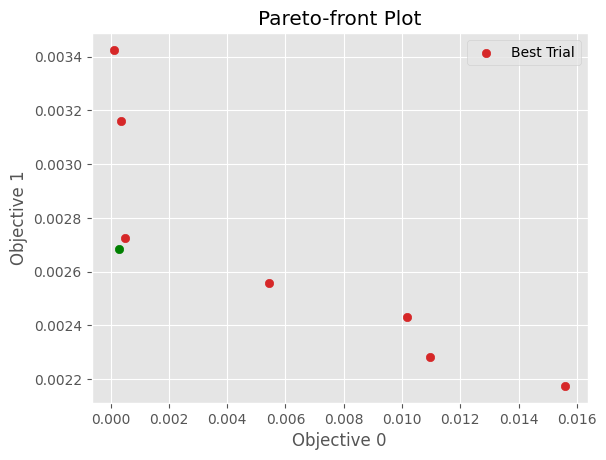

In [192]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [185]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-10.607790178731527
-10.595411199223445
-13.68200901802884
-14.714125717399993
-11.180968295125732
-13.494185884745345
-10.291763558733585


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.01016280282039046, 0.002432661941537903]


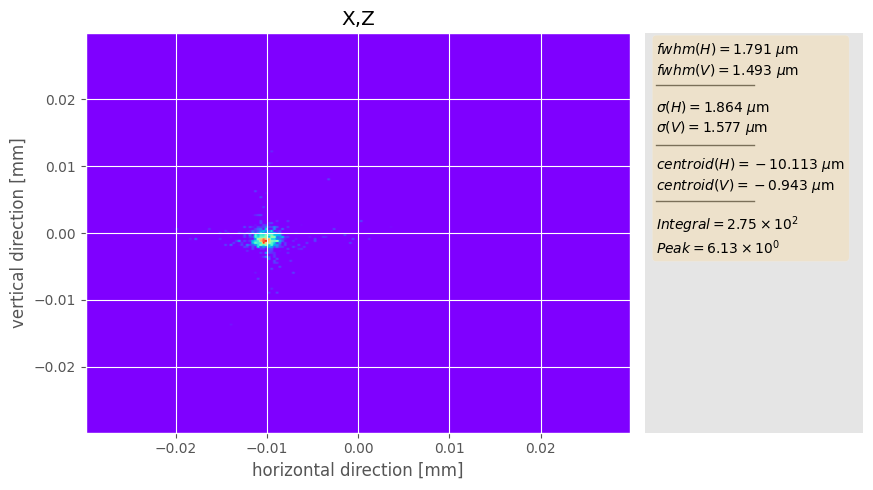

[0.010964054681503677, 0.002282969922579443]


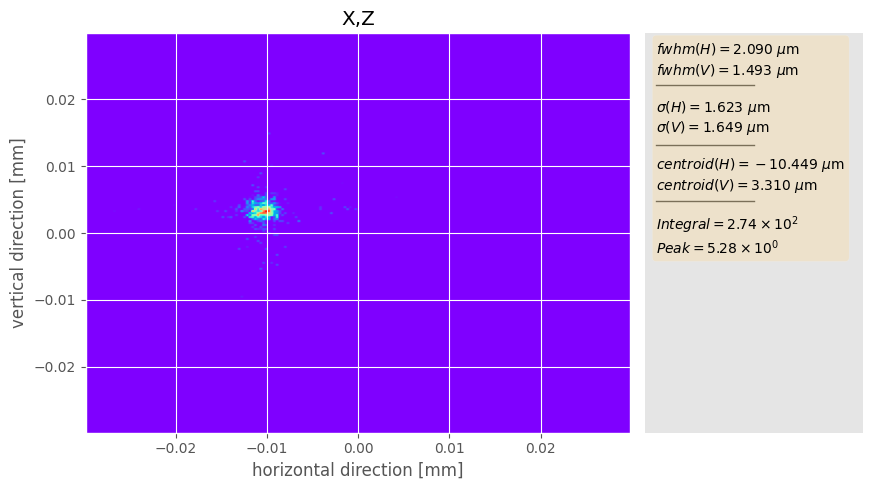

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.00036178996484107753, 0.003158802446357049]


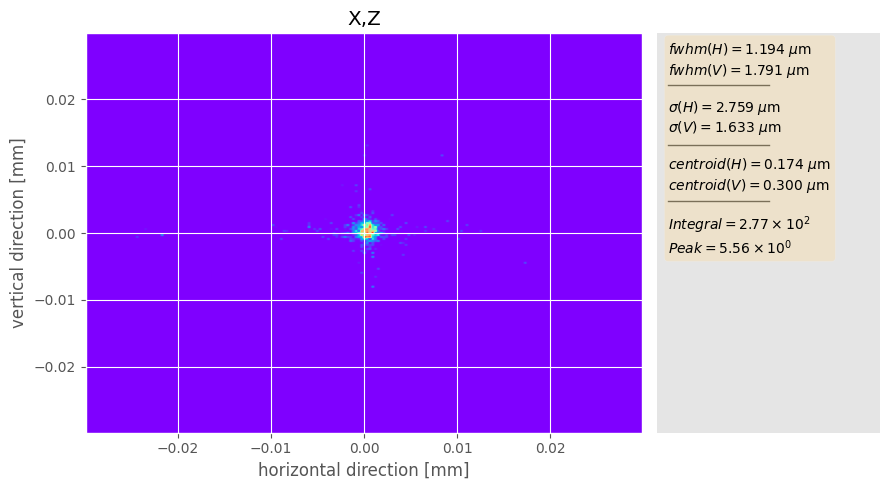

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.00011887661182456844, 0.003424837549498244]


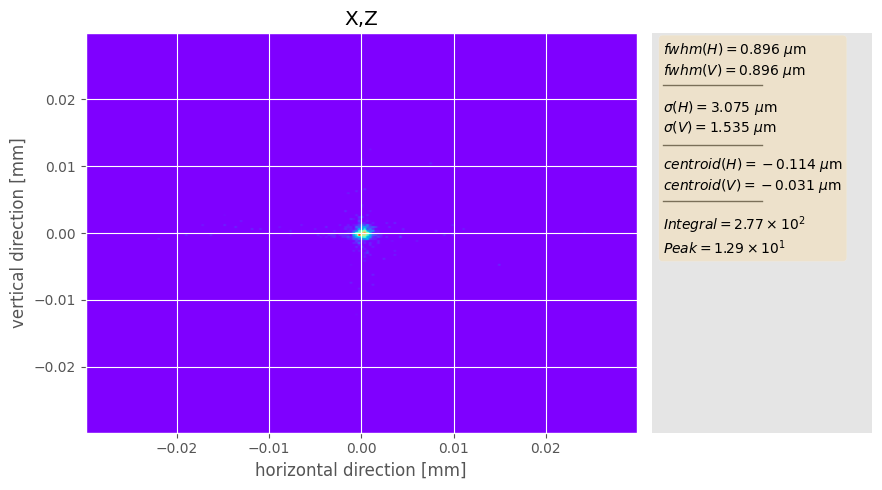

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.005451181512830393, 0.0025566808807582484]


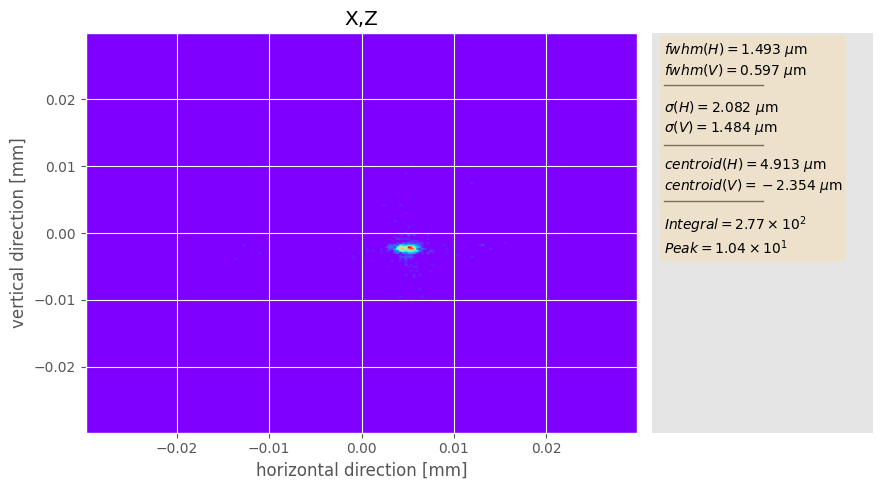

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0005061390170021264, 0.002724455477804195]


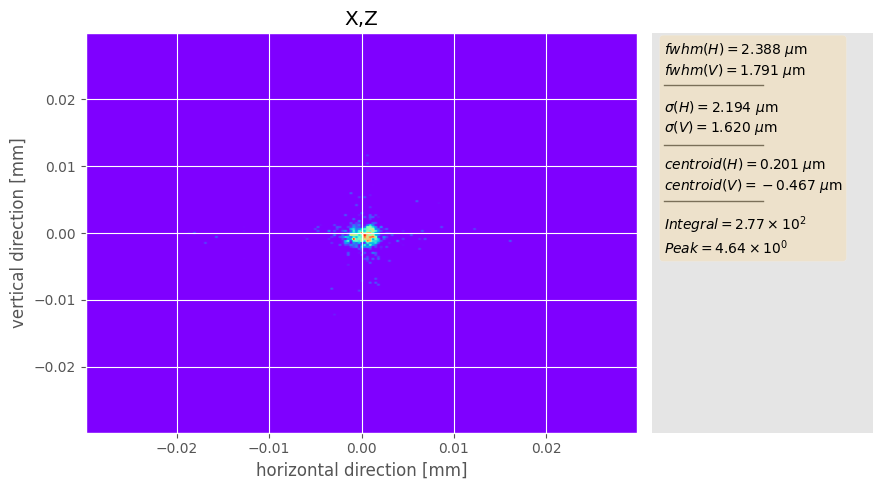

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.015594264760304231, 0.0021745979483993724]


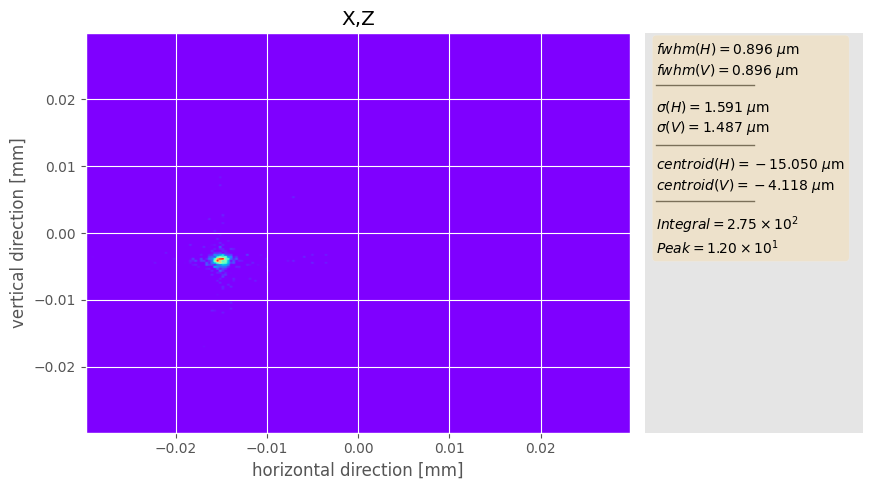

In [186]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Starting same procedure for different random structure 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


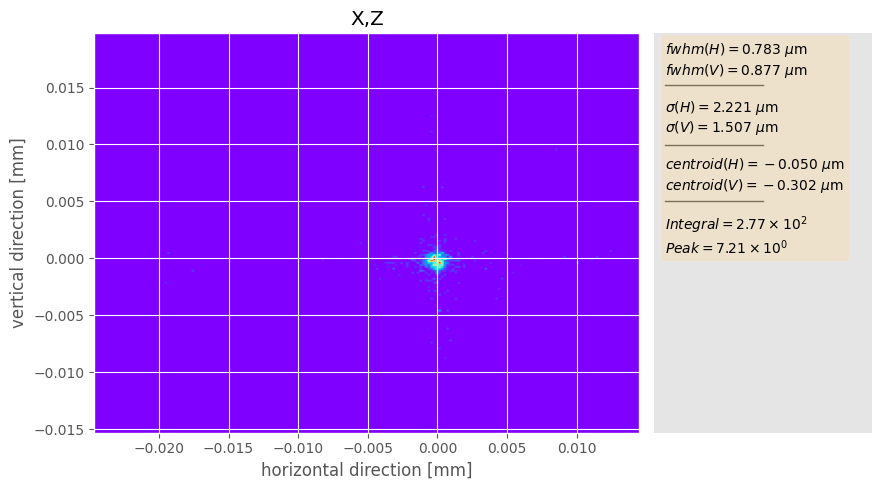

In [190]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [191]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00030356393654879573, 0.0026843803900167464)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir

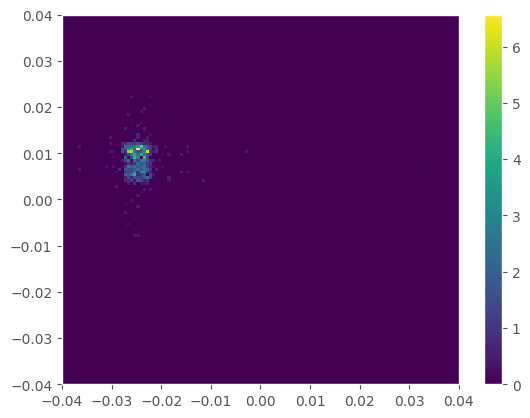

In [193]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], 
                                                                               integral_threshold=100,
                                                                               nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [194]:
hist.data_2D.sum()

276.2617478005642

In [195]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

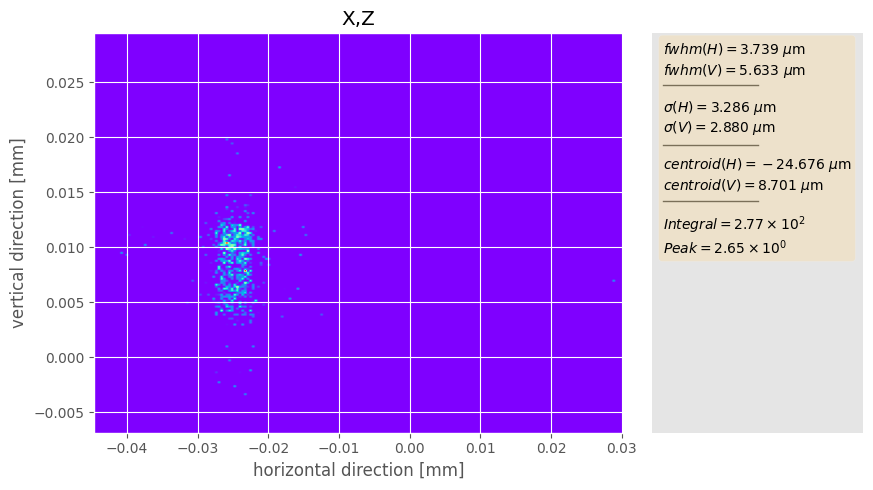

In [196]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [197]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [202]:
base_sampler = optuna.integration.BoTorchSampler()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/3702032374.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler()


In [203]:
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler)

[I 2022-09-24 18:55:30,710] A new study created in memory with name: no-name-98c55cc0-5656-406d-bb5d-a78e8876cef6


In [204]:
opt_trial.trials(200, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/3358725788.py:80: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-09-24 18:55:34,190] Trial 0 finished with values: [0.026031638278904014, 0.00417849043952615] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}. 
[I 2022-09-24 18:55:36,246] Trial 1 pruned. 
[I 2022-09-24 18:55:38,331] Trial 2 finished with values: [0.025384597115952028, 0.006624614101576887] and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.014105206811824214, 'vkb_3': -0.03301868299202268, 'hkb_4': 4.5, 'vkb_4': 4.100000000000001}. 
[I 2022-09-24 18:55:39,887] Trial 3 pruned. 
[I 2022-09-24 18:55:40,992] Trial 4 finished with values: [0.01803285112279566, 0.004205409026121284

In [205]:
opt_trial.study.best_trials

[FrozenTrial(number=30, values=[0.001735917844348931, 0.003401406995333495], datetime_start=datetime.datetime(2022, 9, 24, 18, 56, 49, 733982), datetime_complete=datetime.datetime(2022, 9, 24, 18, 56, 53, 12708), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.008584073464102067, 'hkb_4': -24.0, 'vkb_4': -4.199999999999999}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.001

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


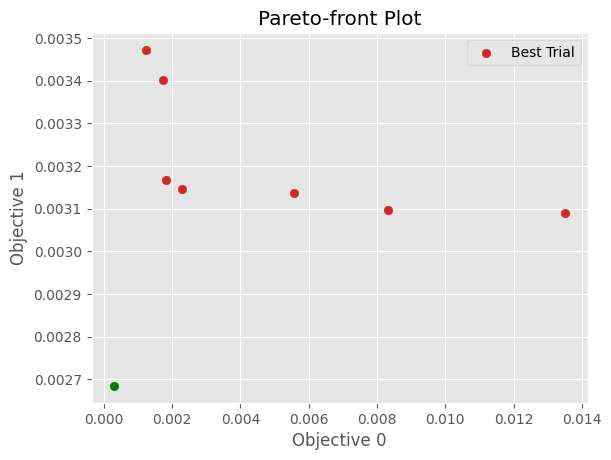

In [206]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [207]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.039785099351509
-12.063620734691455
-11.843504290203636
-10.565851656102785
-12.365707431084065
-10.084662363676813
-10.955758313221923


[0.001735917844348931, 0.003401406995333495]


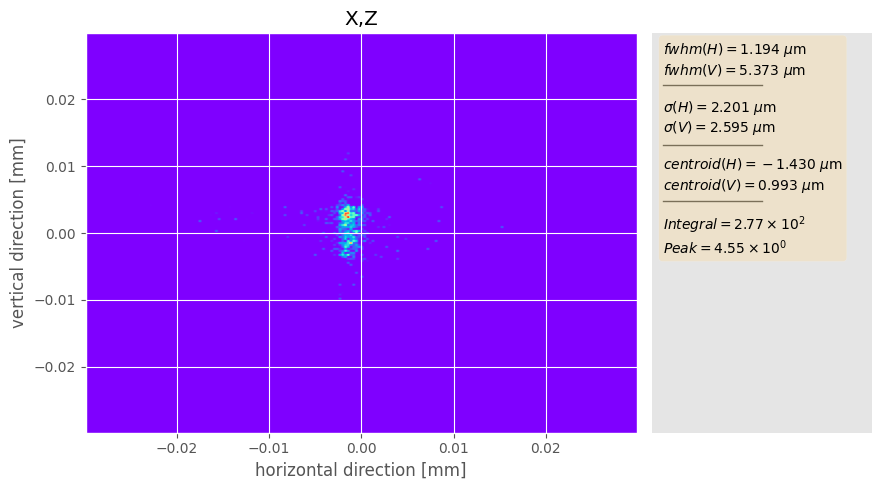

[0.0018202799749291155, 0.0031673633836770917]


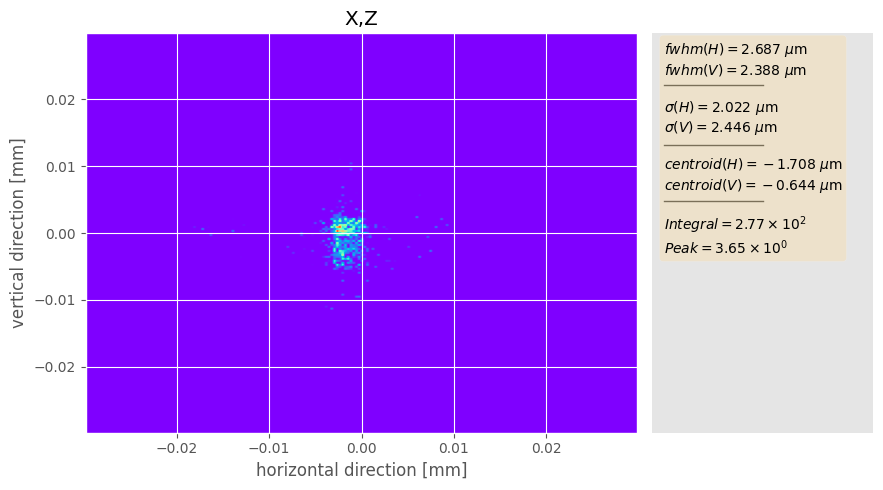

[0.0022841087343178235, 0.0031456809032302784]


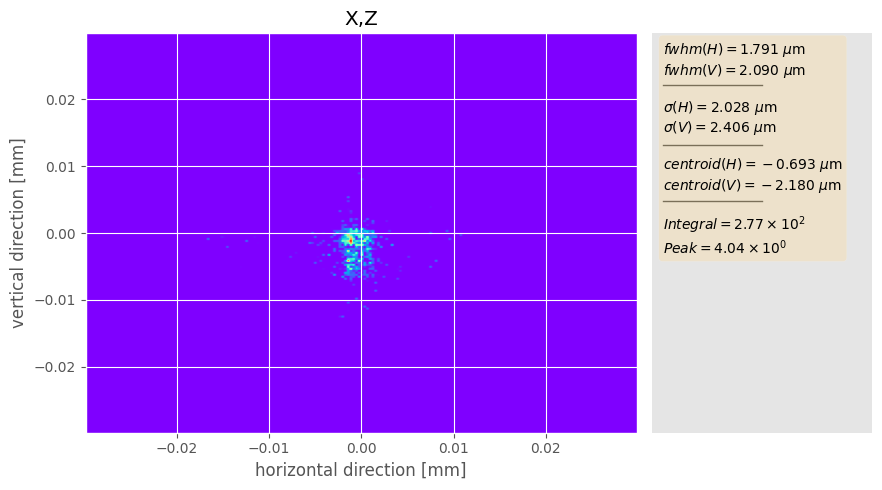

[0.008324400913305746, 0.003097105082865764]


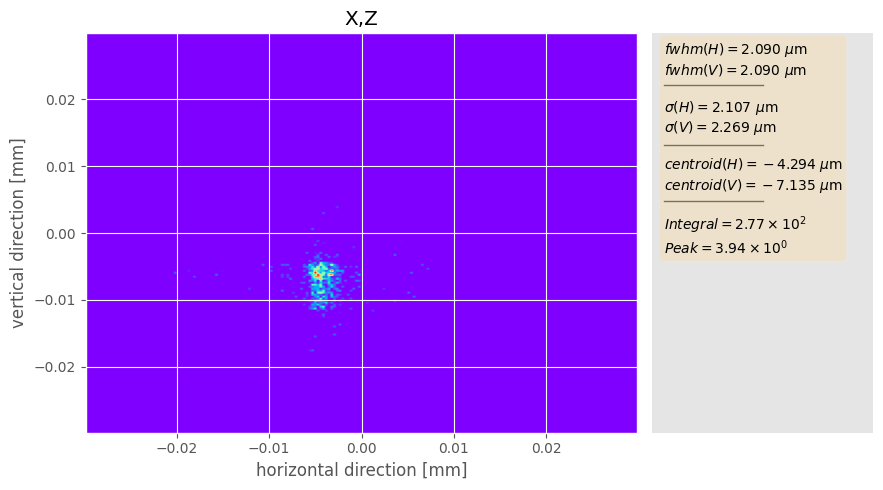

[0.0012275811098926702, 0.003472092614310847]


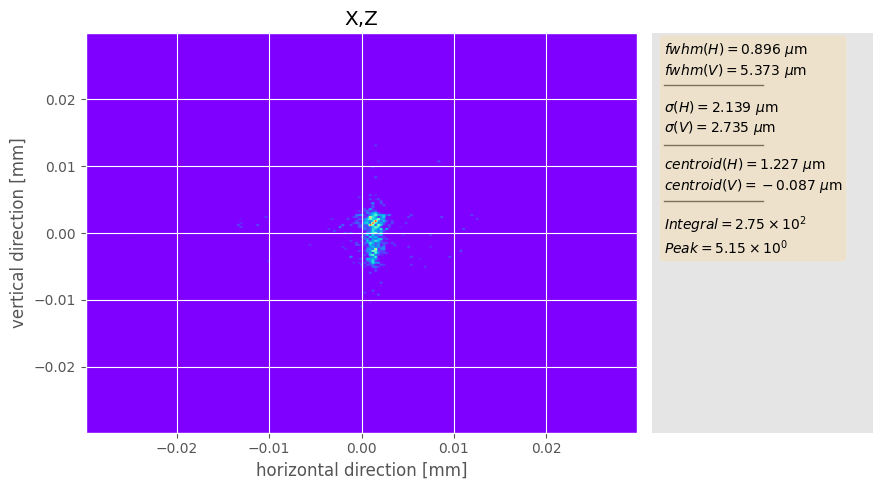

[0.013502755965689932, 0.003089330448420297]


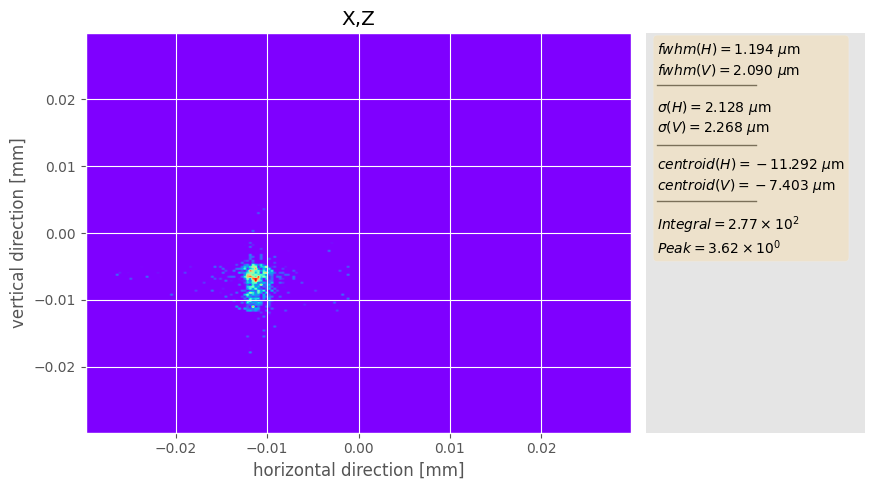

[0.005565647533626858, 0.0031365984248686645]


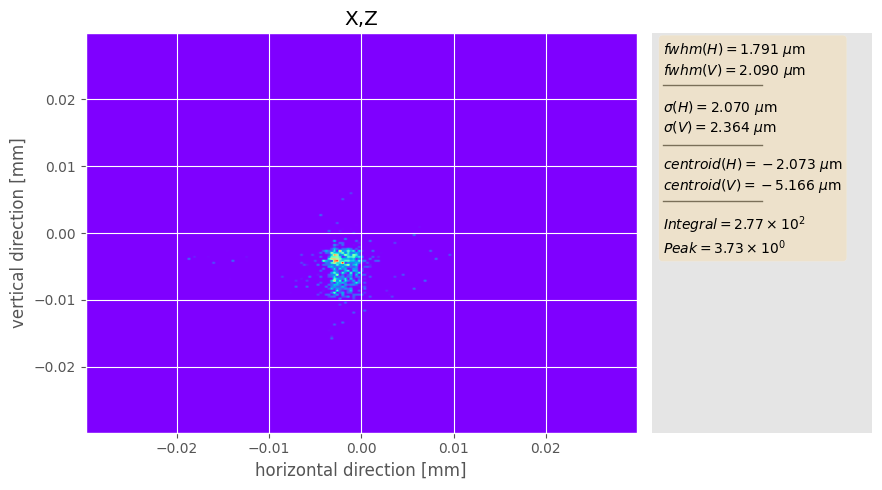

In [208]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [209]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:22,212] Trial 200 finished with values: [0.0076923071059873055, 0.0033461269778882505] and parameters: {'hkb_1': -0.0071000000000012164, 'vkb_1': -17.167, 'hkb_2': 4.298199999999994, 'vkb_2': 27.96539999999999, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.010329402716096399, 'hkb_4': -13.2, 'vkb_4': -2.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:27,307] Trial 201 finished with values: [0.009056499043368216, 0.0033372026976366924] and parameters: {'hkb_1': 4.575299999999999, 'vkb_1': -15.156400000000005, 'hkb_2': -6.1418000000000035, 'vkb_2': 25.0899, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.010329402716096399, 'hkb_4': -21.1, 'vkb_4': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:31,611] Trial 202 finished with values: [0.011201530529323819, 0.0034982233351174953] and parameters: {'hkb_1': 17.343199999999996, 'vkb_1': -22.197400000000002, 'hkb_2': 21.153499999999994, 'vkb_2': 21.76429999999999, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.015565390472079388, 'hkb_4': -10.5, 'vkb_4': -7.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:34,766] Trial 203 finished with values: [0.0014312308717568997, 0.0041874544526348005] and parameters: {'hkb_1': -6.012400000000007, 'vkb_1': 20.55619999999999, 'hkb_2': -10.661300000000004, 'vkb_2': 18.251999999999995, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.008584073464102067, 'hkb_4': -18.7, 'vkb_4': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:37,979] Trial 204 finished with values: [0.0008933817432316213, 0.0037549191868297203] and parameters: {'hkb_1': 5.640799999999992, 'vkb_1': 7.353799999999993, 'hkb_2': 1.0243999999999929, 'vkb_2': 21.653599999999997, 'hkb_3': 0.038539816339744834, 'vkb_3': -0.0016027564561247529, 'hkb_4': -17.0, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:42,013] Trial 205 finished with values: [0.008338777926764539, 0.004032998649818217] and parameters: {'hkb_1': 26.21929999999999, 'vkb_1': 13.810599999999994, 'hkb_2': 26.981099999999998, 'vkb_2': 8.661799999999992, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.022546707480056705, 'hkb_4': -18.4, 'vkb_4': -7.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.w

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:45,780] Trial 206 finished with values: [0.0026288338395469967, 0.002536358416970563] and parameters: {'hkb_1': -13.461300000000001, 'vkb_1': -44.5642, 'hkb_2': 18.82679999999999, 'vkb_2': -11.3123, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.00509341496011341, 'hkb_4': -14.799999999999999, 'vkb_4': -7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:53,317] Trial 207 finished with values: [0.0021253963268003926, 0.0027965867746198715] and parameters: {'hkb_1': 18.161699999999996, 'vkb_1': -45.9013, 'hkb_2': 22.237499999999997, 'vkb_2': -43.7641, 'hkb_3': 0.02806784082777885, 'vkb_3': -0.013820061220085056, 'hkb_4': -18.2, 'vkb_4': -5.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:09:58,669] Trial 208 finished with values: [0.013424678996717504, 0.003194443310051907] and parameters: {'hkb_1': 27.51769999999999, 'vkb_1': -49.9065, 'hkb_2': 26.831799999999987, 'vkb_2': -9.326600000000006, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.0001425727958695791, 'hkb_4': -14.0, 'vkb_4': -3.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:03,117] Trial 209 finished with values: [0.009103140141592959, 0.0027150983135891217] and parameters: {'hkb_1': -20.678, 'vkb_1': -42.1518, 'hkb_2': 14.5869, 'vkb_2': -9.965900000000005, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.008869219055841225, 'hkb_4': -17.2, 'vkb_4': -5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:06,384] Trial 210 finished with values: [0.0018913892024965786, 0.0025334787796508617] and parameters: {'hkb_1': 2.2415999999999983, 'vkb_1': -47.0244, 'hkb_2': 27.081699999999998, 'vkb_2': -28.446, 'hkb_3': 0.038539816339744834, 'vkb_3': -0.008584073464102067, 'hkb_4': -17.9, 'vkb_4': -8.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:10,652] Trial 211 finished with values: [0.0009517135997986102, 0.005155867857485782] and parameters: {'hkb_1': -1.8187000000000069, 'vkb_1': 32.64899999999999, 'hkb_2': 7.814299999999996, 'vkb_2': 46.528699999999986, 'hkb_3': 0.015850536063818546, 'vkb_3': -0.006838744212107742, 'hkb_4': -22.0, 'vkb_4': -5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:15,020] Trial 212 finished with values: [0.007926627386323432, 0.0029817160931962516] and parameters: {'hkb_1': -26.704400000000003, 'vkb_1': -42.9917, 'hkb_2': 42.06689999999999, 'vkb_2': -28.959000000000003, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.008584073464102067, 'hkb_4': -20.6, 'vkb_4': -7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:20,877] Trial 213 finished with values: [0.0037296626109016386, 0.0029818324991477043] and parameters: {'hkb_1': 42.0787, 'vkb_1': -14.975900000000003, 'hkb_2': -1.4321000000000055, 'vkb_2': -28.467200000000002, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.005378560551852568, 'hkb_4': -21.2, 'vkb_4': -9.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:25,773] Trial 214 finished with values: [0.006663838055638597, 0.0026068830953319216] and parameters: {'hkb_1': 3.4499999999999957, 'vkb_1': -45.7271, 'hkb_2': 13.709799999999994, 'vkb_2': -4.076400000000007, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.00509341496011341, 'hkb_4': -18.9, 'vkb_4': -6.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:29,081] Trial 215 finished with values: [0.0073935073805460865, 0.002706879969353868] and parameters: {'hkb_1': -27.0317, 'vkb_1': -34.2649, 'hkb_2': -0.9936000000000078, 'vkb_2': -15.602600000000002, 'hkb_3': 0.033303828583761845, 'vkb_3': -0.003348085708119078, 'hkb_4': -11.2, 'vkb_4': -7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:33,766] Trial 216 finished with values: [0.007887193854138653, 0.002644719249040477] and parameters: {'hkb_1': -1.8350000000000009, 'vkb_1': -39.6382, 'hkb_2': -11.827200000000005, 'vkb_2': -20.252100000000002, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.003348085708119078, 'hkb_4': -19.2, 'vkb_4': -11.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:38,398] Trial 217 finished with values: [0.010026992360342647, 0.002941524549748056] and parameters: {'hkb_1': 20.863799999999998, 'vkb_1': -21.0267, 'hkb_2': -15.331200000000003, 'vkb_2': -39.2277, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.003633231299858236, 'hkb_4': -15.299999999999999, 'vkb_4': -8.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:42,438] Trial 218 finished with values: [0.0050223298214365, 0.002726098324576195] and parameters: {'hkb_1': 24.08699999999999, 'vkb_1': -31.249100000000002, 'hkb_2': 5.897299999999994, 'vkb_2': -23.477300000000003, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.0016027564561247529, 'hkb_4': -19.5, 'vkb_4': -4.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:46,564] Trial 219 finished with values: [0.007042088955942313, 0.002965286567530992] and parameters: {'hkb_1': -17.573, 'vkb_1': -30.663500000000003, 'hkb_2': -42.6689, 'vkb_2': -46.7665, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.006838744212107742, 'hkb_4': -20.6, 'vkb_4': -5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:51,883] Trial 220 finished with values: [0.013287954865134488, 0.0029333114999970026] and parameters: {'hkb_1': 22.89049999999999, 'vkb_1': -48.8554, 'hkb_2': 19.20049999999999, 'vkb_2': -26.3106, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.019341194567807203, 'hkb_4': -17.799999999999997, 'vkb_4': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:10:57,019] Trial 221 finished with values: [0.004418799708306636, 0.0052965769178364205] and parameters: {'hkb_1': 41.629599999999996, 'vkb_1': 43.562499999999986, 'hkb_2': -8.209400000000002, 'vkb_2': 33.9451, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.0001425727958695791, 'hkb_4': -24.9, 'vkb_4': -13.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:02,254] Trial 222 finished with values: [0.007940190899353897, 0.002731818401950146] and parameters: {'hkb_1': -12.895900000000005, 'vkb_1': -46.3252, 'hkb_2': -26.020400000000002, 'vkb_2': -13.1858, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.008584073464102067, 'hkb_4': -23.1, 'vkb_4': -8.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:06,403] Trial 223 finished with values: [0.005821052799575055, 0.0026993197390603437] and parameters: {'hkb_1': -28.360000000000003, 'vkb_1': -49.6637, 'hkb_2': -11.456300000000006, 'vkb_2': -5.595900000000007, 'hkb_3': 0.014105206811824214, 'vkb_3': -0.012074731968090727, 'hkb_4': -18.0, 'vkb_4': -7.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:09,861] Trial 224 finished with values: [0.0044504625329276045, 0.0030731902700124165] and parameters: {'hkb_1': -49.629, 'vkb_1': -44.4415, 'hkb_2': 5.269299999999994, 'vkb_2': -35.7034, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.013820061220085056, 'hkb_4': -16.9, 'vkb_4': 0.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:13,923] Trial 225 finished with values: [0.007655576830463864, 0.0028946703700748417] and parameters: {'hkb_1': 15.794399999999996, 'vkb_1': -44.0351, 'hkb_2': -27.733900000000002, 'vkb_2': -38.9279, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.005378560551852568, 'hkb_4': -13.8, 'vkb_4': -6.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:17,798] Trial 226 finished with values: [0.0016048698241317185, 0.0032579894551726125] and parameters: {'hkb_1': -39.401700000000005, 'vkb_1': -21.917500000000004, 'hkb_2': -27.861300000000004, 'vkb_2': -47.8337, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.012074731968090727, 'hkb_4': -25.8, 'vkb_4': -2.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:23,443] Trial 227 finished with values: [0.011019230105511722, 0.0033639984681641862] and parameters: {'hkb_1': 34.08709999999999, 'vkb_1': -43.2002, 'hkb_2': -21.892400000000002, 'vkb_2': 4.7930999999999955, 'hkb_3': 0.012359877559829889, 'vkb_3': -0.019056048976068045, 'hkb_4': -13.7, 'vkb_4': -9.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:27,244] Trial 228 finished with values: [0.0026815027969862293, 0.002544461918831054] and parameters: {'hkb_1': -8.8048, 'vkb_1': -50.0, 'hkb_2': 2.593199999999996, 'vkb_2': -44.7747, 'hkb_3': 0.02806784082777885, 'vkb_3': -0.0016027564561247529, 'hkb_4': -18.4, 'vkb_4': -6.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:31,440] Trial 229 finished with values: [0.01308477782001446, 0.0027506499449766117] and parameters: {'hkb_1': 3.199799999999996, 'vkb_1': -45.3437, 'hkb_2': -35.044, 'vkb_2': -38.1268, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.012074731968090727, 'hkb_4': -12.8, 'vkb_4': -9.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:35,736] Trial 230 finished with values: [0.0006222003168331856, 0.0034490236072707895] and parameters: {'hkb_1': -35.0824, 'vkb_1': -44.5045, 'hkb_2': 0.22449999999999903, 'vkb_2': -9.267000000000003, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.020801378228062377, 'hkb_4': -21.4, 'vkb_4': -1.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:39,592] Trial 231 finished with values: [0.004398651128613788, 0.0030664262378767917] and parameters: {'hkb_1': -31.7769, 'vkb_1': -11.078300000000006, 'hkb_2': 39.24499999999999, 'vkb_2': -22.186400000000003, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.0016027564561247529, 'hkb_4': -20.299999999999997, 'vkb_4': -13.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:43,139] Trial 232 finished with values: [0.009724349690076415, 0.0030248968915425603] and parameters: {'hkb_1': -47.4843, 'vkb_1': -44.735, 'hkb_2': -2.241500000000002, 'vkb_2': -42.5634, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.013820061220085056, 'hkb_4': -24.5, 'vkb_4': -11.8}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:48,288] Trial 233 finished with values: [0.005352441665443269, 0.0029576993278990584] and parameters: {'hkb_1': 20.612499999999997, 'vkb_1': -48.6695, 'hkb_2': -38.9769, 'vkb_2': -16.800700000000006, 'hkb_3': 0.0001425727958695791, 'vkb_3': -0.0016027564561247529, 'hkb_4': -22.7, 'vkb_4': -5.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:52,851] Trial 234 finished with values: [0.011483352453940013, 0.0035706847801572307] and parameters: {'hkb_1': -40.7143, 'vkb_1': -25.887800000000002, 'hkb_2': -48.4637, 'vkb_2': -25.1366, 'hkb_3': 0.012359877559829889, 'vkb_3': -0.026037365984045366, 'hkb_4': -20.299999999999997, 'vkb_4': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:11:56,827] Trial 235 finished with values: [0.0012713111134234204, 0.0026716446574970433] and parameters: {'hkb_1': 7.168299999999995, 'vkb_1': -50.0, 'hkb_2': 23.147299999999987, 'vkb_2': -37.0509, 'hkb_3': 0.038539816339744834, 'vkb_3': -0.0016027564561247529, 'hkb_4': -16.0, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:02,863] Trial 236 finished with values: [0.010429526564569034, 0.003037271973348353] and parameters: {'hkb_1': 41.4657, 'vkb_1': -41.5341, 'hkb_2': 2.048499999999997, 'vkb_2': -35.585, 'hkb_3': -0.003348085708119078, 'vkb_3': 0.003633231299858236, 'hkb_4': -18.0, 'vkb_4': -5.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:07,479] Trial 237 finished with values: [0.00903425805237826, 0.00322143431858476] and parameters: {'hkb_1': -33.3855, 'vkb_1': -41.4564, 'hkb_2': 24.034999999999997, 'vkb_2': 26.328799999999987, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.010614548307835557, 'hkb_4': -22.1, 'vkb_4': -7.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:10,938] Trial 238 finished with values: [0.007067407670776868, 0.0029728735905775743] and parameters: {'hkb_1': -31.776300000000003, 'vkb_1': -26.9403, 'hkb_2': -38.9289, 'vkb_2': -48.9873, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.015565390472079388, 'hkb_4': -15.6, 'vkb_4': -8.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:15,968] Trial 239 finished with values: [0.004624984514792246, 0.0030678457093000987] and parameters: {'hkb_1': -11.246100000000006, 'vkb_1': -49.6551, 'hkb_2': 25.0509, 'vkb_2': 32.712199999999996, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.00509341496011341, 'hkb_4': -19.4, 'vkb_4': -12.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:21,666] Trial 240 finished with values: [0.016043478077688814, 0.002487201184091353] and parameters: {'hkb_1': -11.369700000000002, 'vkb_1': -45.7093, 'hkb_2': -26.0379, 'vkb_2': -36.5085, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.017310719724073716, 'hkb_4': -13.2, 'vkb_4': -6.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:27,353] Trial 241 finished with values: [0.0075301687350263265, 0.002663047718857975] and parameters: {'hkb_1': -10.616500000000002, 'vkb_1': -30.2696, 'hkb_2': 23.0715, 'vkb_2': -42.5859, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.00509341496011341, 'hkb_4': -19.6, 'vkb_4': -9.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:33,397] Trial 242 finished with values: [0.0037684432679496124, 0.003382473415580993] and parameters: {'hkb_1': 21.591399999999993, 'vkb_1': -40.6698, 'hkb_2': -23.1838, 'vkb_2': -37.5677, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.019056048976068045, 'hkb_4': -11.8, 'vkb_4': -2.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:37,592] Trial 243 finished with values: [0.005600406518849986, 0.0030265998243425326] and parameters: {'hkb_1': -44.8681, 'vkb_1': -25.924500000000002, 'hkb_2': -29.9705, 'vkb_2': -45.9913, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.001887902047863911, 'hkb_4': -15.0, 'vkb_4': -6.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:43,408] Trial 244 finished with values: [0.00501368047094385, 0.002718043254893742] and parameters: {'hkb_1': -7.403800000000004, 'vkb_1': -48.1563, 'hkb_2': 12.713899999999995, 'vkb_2': -16.908700000000003, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.003633231299858236, 'hkb_4': -23.4, 'vkb_4': -11.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:51,508] Trial 245 finished with values: [0.012955625504928665, 0.0031841106507619903] and parameters: {'hkb_1': 42.67769999999999, 'vkb_1': -36.631, 'hkb_2': -1.8336000000000041, 'vkb_2': -48.9641, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.013820061220085056, 'hkb_4': -16.6, 'vkb_4': -8.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:12:55,883] Trial 246 finished with values: [0.011244769413012659, 0.0033352050067944035] and parameters: {'hkb_1': -42.838, 'vkb_1': -48.4554, 'hkb_2': -32.6456, 'vkb_2': -43.2633, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.010614548307835557, 'hkb_4': -18.0, 'vkb_4': -3.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:00,775] Trial 247 finished with values: [0.005321048540788239, 0.0026965295434117063] and parameters: {'hkb_1': 0.38219999999999743, 'vkb_1': -25.622700000000002, 'hkb_2': 27.30829999999999, 'vkb_2': -42.9962, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.013820061220085056, 'hkb_4': -15.399999999999999, 'vkb_4': -8.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:04,932] Trial 248 finished with values: [0.002226314357045673, 0.005260048663723003] and parameters: {'hkb_1': -17.250600000000006, 'vkb_1': 11.774399999999993, 'hkb_2': -23.535800000000002, 'vkb_2': 49.155199999999994, 'hkb_3': 0.015850536063818546, 'vkb_3': -0.012074731968090727, 'hkb_4': -24.6, 'vkb_4': -4.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:09,914] Trial 249 finished with values: [0.0014434461009088658, 0.0032083853745373723] and parameters: {'hkb_1': 18.45859999999999, 'vkb_1': -50.0, 'hkb_2': -10.816100000000006, 'vkb_2': -24.078000000000003, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.019056048976068045, 'hkb_4': -21.4, 'vkb_4': -1.0999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:15,532] Trial 250 finished with values: [0.007042692931949217, 0.002822751900122246] and parameters: {'hkb_1': 44.373699999999985, 'vkb_1': -49.8228, 'hkb_2': -10.512500000000003, 'vkb_2': -40.6122, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.008869219055841225, 'hkb_4': -20.1, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:21,905] Trial 251 finished with values: [0.0025854596246106067, 0.003337126989116674] and parameters: {'hkb_1': 44.99789999999999, 'vkb_1': -14.9499, 'hkb_2': 38.8373, 'vkb_2': -43.9398, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.00509341496011341, 'hkb_4': -23.1, 'vkb_4': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:26,821] Trial 252 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:32,381] Trial 253 finished with values: [0.003022044988399793, 0.003212239612015022] and parameters: {'hkb_1': 21.34559999999999, 'vkb_1': -43.2242, 'hkb_2': -2.817600000000006, 'vkb_2': -38.5448, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.006838744212107742, 'hkb_4': -23.9, 'vkb_4': -8.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:38,438] Trial 254 finished with values: [0.01128782066296656, 0.0033148632937122714] and parameters: {'hkb_1': 8.028199999999998, 'vkb_1': -33.9418, 'hkb_2': -45.6689, 'vkb_2': -47.5466, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.021086523819801535, 'hkb_4': -21.1, 'vkb_4': -9.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:42,199] Trial 255 finished with values: [0.00477341229844502, 0.002637738956600295] and parameters: {'hkb_1': -34.636700000000005, 'vkb_1': -50.0, 'hkb_2': 14.21499999999999, 'vkb_2': -26.786600000000004, 'hkb_3': 0.02981317007977318, 'vkb_3': -0.012074731968090727, 'hkb_4': -15.0, 'vkb_4': -4.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:49,129] Trial 256 finished with values: [0.023539303724854604, 0.0022166131359942164] and parameters: {'hkb_1': -35.7706, 'vkb_1': -49.9904, 'hkb_2': -0.2284000000000077, 'vkb_2': -28.0166, 'hkb_3': -0.036509341496011344, 'vkb_3': -0.008584073464102067, 'hkb_4': -12.399999999999999, 'vkb_4': -5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:53,677] Trial 257 finished with values: [0.009556742237433621, 0.011009147458733645] and parameters: {'hkb_1': -11.058100000000003, 'vkb_1': -33.5508, 'hkb_2': -49.6911, 'vkb_2': -5.684600000000003, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.027782695236039694, 'hkb_4': -23.8, 'vkb_4': 5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:13:59,092] Trial 258 finished with values: [0.015385169336893144, 0.002817509667176464] and parameters: {'hkb_1': -46.0021, 'vkb_1': 2.5241999999999933, 'hkb_2': 5.307099999999998, 'vkb_2': -45.932900000000004, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.013820061220085056, 'hkb_4': -15.2, 'vkb_4': -11.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:03,809] Trial 259 finished with values: [0.014415647153083737, 0.002309970034580817] and parameters: {'hkb_1': -44.9518, 'vkb_1': -40.9974, 'hkb_2': 17.862899999999996, 'vkb_2': -32.044700000000006, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.008584073464102067, 'hkb_4': -16.2, 'vkb_4': -9.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:10,488] Trial 260 finished with values: [0.015183925724586232, 0.0029368931471040662] and parameters: {'hkb_1': 8.608999999999995, 'vkb_1': -33.303, 'hkb_2': 38.699799999999996, 'vkb_2': -48.0043, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.010329402716096399, 'hkb_4': -19.9, 'vkb_4': -0.5999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:15,013] Trial 261 finished with values: [0.011856507990481005, 0.002561775340713338] and parameters: {'hkb_1': -22.53, 'vkb_1': -49.3618, 'hkb_2': -34.0798, 'vkb_2': -20.278000000000002, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.001887902047863911, 'hkb_4': -11.5, 'vkb_4': -9.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:19,828] Trial 262 finished with values: [0.020055394834016492, 0.0032048776266166363] and parameters: {'hkb_1': -48.4975, 'vkb_1': -17.569000000000003, 'hkb_2': 20.9122, 'vkb_2': -8.660700000000006, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.022546707480056705, 'hkb_4': -9.399999999999999, 'vkb_4': -2.6999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:25,060] Trial 263 finished with values: [0.022983479328827335, 0.0023642685846425263] and parameters: {'hkb_1': -46.5504, 'vkb_1': -19.858700000000002, 'hkb_2': 38.5402, 'vkb_2': -36.7169, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.0016027564561247529, 'hkb_4': -8.399999999999999, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:30,676] Trial 264 finished with values: [0.023053140589971953, 0.0024795468739961697] and parameters: {'hkb_1': -43.8686, 'vkb_1': -49.769, 'hkb_2': -20.953100000000003, 'vkb_2': -34.2917, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.005378560551852568, 'hkb_4': -13.5, 'vkb_4': -9.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:35,227] Trial 265 finished with values: [0.003827756854802272, 0.002639623292628848] and parameters: {'hkb_1': 18.524599999999992, 'vkb_1': -33.7225, 'hkb_2': 15.949699999999993, 'vkb_2': -44.460300000000004, 'hkb_3': 0.019341194567807203, 'vkb_3': -0.010329402716096399, 'hkb_4': -19.9, 'vkb_4': -1.3999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:40,623] Trial 266 finished with values: [0.022456901440854285, 0.0027941920765077654] and parameters: {'hkb_1': -21.052000000000003, 'vkb_1': 4.238899999999994, 'hkb_2': 45.391099999999994, 'vkb_2': -19.288200000000003, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.008584073464102067, 'hkb_4': -10.7, 'vkb_4': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:46,034] Trial 267 finished with values: [0.017233336407114, 0.0027785620668716606] and parameters: {'hkb_1': -4.528600000000004, 'vkb_1': -45.9059, 'hkb_2': -20.642000000000003, 'vkb_2': -46.6465, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.020801378228062377, 'hkb_4': -8.5, 'vkb_4': -7.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:50,473] Trial 268 finished with values: [0.01071999304391747, 0.0032005992477166204] and parameters: {'hkb_1': -29.323600000000003, 'vkb_1': -47.1791, 'hkb_2': 29.099999999999994, 'vkb_2': -38.2237, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0001425727958695791, 'hkb_4': -20.799999999999997, 'vkb_4': 0.7000000000000028}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:14:56,180] Trial 269 finished with values: [0.009900130420905305, 0.003383997139085668] and parameters: {'hkb_1': -10.486400000000003, 'vkb_1': -47.0769, 'hkb_2': 42.15499999999999, 'vkb_2': 12.691499999999998, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.020801378228062377, 'hkb_4': -25.6, 'vkb_4': -9.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:03,422] Trial 270 finished with values: [0.008531725524144714, 0.0030752660094267247] and parameters: {'hkb_1': -20.8561, 'vkb_1': -49.5304, 'hkb_2': -46.9623, 'vkb_2': -49.3311, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.003348085708119078, 'hkb_4': -21.4, 'vkb_4': -1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:08,564] Trial 271 finished with values: [0.01817487968308034, 0.0029618804966099845] and parameters: {'hkb_1': -4.092400000000005, 'vkb_1': 4.751099999999994, 'hkb_2': 27.76719999999999, 'vkb_2': -46.1181, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.0001425727958695791, 'hkb_4': -6.799999999999997, 'vkb_4': -5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:13,290] Trial 272 finished with values: [0.011090745431772672, 0.0026748735503581444] and parameters: {'hkb_1': -1.6777000000000015, 'vkb_1': -30.6275, 'hkb_2': 8.930399999999992, 'vkb_2': -46.2641, 'hkb_3': 0.02806784082777885, 'vkb_3': -0.006838744212107742, 'hkb_4': -8.399999999999999, 'vkb_4': -10.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:19,762] Trial 273 finished with values: [0.026286831827496505, 0.0023355281936237485] and parameters: {'hkb_1': -17.4429, 'vkb_1': -44.5374, 'hkb_2': 12.983699999999992, 'vkb_2': -47.3339, 'hkb_3': -0.027782695236039694, 'vkb_3': 0.019341194567807203, 'hkb_4': -9.7, 'vkb_4': -7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:25,615] Trial 274 finished with values: [0.017271218875380925, 0.0028307857497999207] and parameters: {'hkb_1': -31.825000000000003, 'vkb_1': -27.6992, 'hkb_2': 35.0235, 'vkb_2': -40.211, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.019341194567807203, 'hkb_4': -11.099999999999998, 'vkb_4': -10.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:30,359] Trial 275 finished with values: [0.00912224110249943, 0.0026283973904686012] and parameters: {'hkb_1': -46.3344, 'vkb_1': -50.0, 'hkb_2': 37.459999999999994, 'vkb_2': -50.0, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.001887902047863911, 'hkb_4': -11.2, 'vkb_4': -8.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:35,590] Trial 276 finished with values: [0.00034587220251211715, 0.0045542447036153715] and parameters: {'hkb_1': -4.5460000000000065, 'vkb_1': -40.5766, 'hkb_2': 16.913299999999992, 'vkb_2': -27.9402, 'hkb_3': 0.0001425727958695791, 'vkb_3': -0.020801378228062377, 'hkb_4': -28.3, 'vkb_4': -0.3999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:40,412] Trial 277 finished with values: [0.008347729307455996, 0.0032574229136138905] and parameters: {'hkb_1': -45.376400000000004, 'vkb_1': -43.6798, 'hkb_2': -21.863400000000002, 'vkb_2': -34.7858, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.010329402716096399, 'hkb_4': -23.0, 'vkb_4': -12.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:45,663] Trial 278 finished with values: [0.014211443267200545, 0.0027349475072122272] and parameters: {'hkb_1': -37.1323, 'vkb_1': -35.9269, 'hkb_2': 45.3253, 'vkb_2': -19.578200000000002, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.020801378228062377, 'hkb_4': -13.3, 'vkb_4': -4.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:50,887] Trial 279 finished with values: [0.019022493298298804, 0.003197490217955462] and parameters: {'hkb_1': 26.55619999999999, 'vkb_1': -49.0117, 'hkb_2': 27.946299999999994, 'vkb_2': -24.750500000000002, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.001887902047863911, 'hkb_4': -0.7999999999999972, 'vkb_4': -9.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:15:56,736] Trial 280 finished with values: [0.02473687409384425, 0.0024262301925632524] and parameters: {'hkb_1': -27.392300000000002, 'vkb_1': -25.274700000000003, 'hkb_2': -21.659800000000004, 'vkb_2': -43.1408, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.0071238898038469, 'hkb_4': -6.899999999999999, 'vkb_4': -8.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:02,632] Trial 281 finished with values: [0.008864575995411685, 0.002664626362819353] and parameters: {'hkb_1': -18.020400000000002, 'vkb_1': -43.5833, 'hkb_2': -10.482600000000005, 'vkb_2': -17.4277, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.010329402716096399, 'hkb_4': -15.799999999999999, 'vkb_4': -9.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:09,105] Trial 282 finished with values: [0.020676225076223066, 0.002303961619345989] and parameters: {'hkb_1': -36.3599, 'vkb_1': -46.7828, 'hkb_2': 2.769199999999998, 'vkb_2': -32.941500000000005, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.033303828583761845, 'hkb_4': -10.599999999999998, 'vkb_4': -9.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:16,201] Trial 283 finished with values: [0.030124748710243676, 0.0028094800071610934] and parameters: {'hkb_1': 12.051399999999994, 'vkb_1': -49.9154, 'hkb_2': -35.1135, 'vkb_2': -0.12510000000000332, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.0245771823237902, 'hkb_4': -7.5, 'vkb_4': -7.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:21,923] Trial 284 finished with values: [0.015841230694864573, 0.003110652360121065] and parameters: {'hkb_1': -36.8385, 'vkb_1': 8.736999999999995, 'hkb_2': -31.971600000000002, 'vkb_2': -43.6955, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.019341194567807203, 'hkb_4': -11.2, 'vkb_4': -8.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:25,990] Trial 285 finished with values: [0.010448440792838675, 0.002922929509849258] and parameters: {'hkb_1': -35.8382, 'vkb_1': -11.9161, 'hkb_2': 17.29719999999999, 'vkb_2': -45.044, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.013820061220085056, 'hkb_4': -10.399999999999999, 'vkb_4': -8.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:31,751] Trial 286 finished with values: [0.01361022452846091, 0.0029299547300220283] and parameters: {'hkb_1': 12.075299999999991, 'vkb_1': -35.8294, 'hkb_2': 44.285799999999995, 'vkb_2': -36.3857, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.00509341496011341, 'hkb_4': -11.399999999999999, 'vkb_4': -8.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:37,774] Trial 287 finished with values: [0.017409424152661803, 0.00287843538711117] and parameters: {'hkb_1': 1.5965999999999951, 'vkb_1': -27.9886, 'hkb_2': 22.04979999999999, 'vkb_2': -33.0565, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.02981317007977318, 'hkb_4': -11.599999999999998, 'vkb_4': -9.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:43,910] Trial 288 finished with values: [0.027301663442731005, 0.002475501272624974] and parameters: {'hkb_1': -49.8085, 'vkb_1': -42.6198, 'hkb_2': -21.4981, 'vkb_2': -16.0546, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.02806784082777885, 'hkb_4': -2.099999999999998, 'vkb_4': -7.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:50,668] Trial 289 finished with values: [0.02360602793470363, 0.0035614421827284432] and parameters: {'hkb_1': -34.275400000000005, 'vkb_1': 12.711899999999993, 'hkb_2': 45.29729999999999, 'vkb_2': 7.649599999999992, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.026322511575784517, 'hkb_4': -4.599999999999998, 'vkb_4': -7.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:16:56,187] Trial 290 finished with values: [0.014573574476375991, 0.003026219151162122] and parameters: {'hkb_1': -28.166800000000002, 'vkb_1': -49.6376, 'hkb_2': -12.839400000000005, 'vkb_2': -48.2855, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.036509341496011344, 'hkb_4': -16.1, 'vkb_4': -7.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:01,297] Trial 291 finished with values: [0.014574506620909283, 0.003644435015603285] and parameters: {'hkb_1': -10.578800000000001, 'vkb_1': -48.1429, 'hkb_2': -7.251800000000003, 'vkb_2': -43.9378, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.010329402716096399, 'hkb_4': -2.099999999999998, 'vkb_4': -8.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:08,363] Trial 292 finished with values: [0.021412459709154077, 0.0027827443109679703] and parameters: {'hkb_1': -0.8710000000000022, 'vkb_1': -46.0807, 'hkb_2': 34.50059999999999, 'vkb_2': -27.977100000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.010614548307835557, 'hkb_4': -3.799999999999997, 'vkb_4': -10.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:13,830] Trial 293 finished with values: [0.01588057983757826, 0.0032565889288683693] and parameters: {'hkb_1': -28.638800000000003, 'vkb_1': -48.3555, 'hkb_2': -28.860000000000003, 'vkb_2': 25.648399999999995, 'hkb_3': 0.026322511575784517, 'vkb_3': 0.02806784082777885, 'hkb_4': -13.899999999999999, 'vkb_4': -9.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:20,800] Trial 294 finished with values: [0.02447325701908014, 0.0025364272774912526] and parameters: {'hkb_1': -28.857000000000003, 'vkb_1': -40.4828, 'hkb_2': -14.720600000000005, 'vkb_2': -5.453900000000004, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.0001425727958695791, 'hkb_4': -10.299999999999997, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:25,052] Trial 295 finished with values: [0.008959471929247424, 0.0028498936636342214] and parameters: {'hkb_1': -43.2231, 'vkb_1': -22.422500000000003, 'hkb_2': 30.3446, 'vkb_2': -46.2604, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.013820061220085056, 'hkb_4': -18.9, 'vkb_4': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:31,509] Trial 296 finished with values: [0.003572337181219203, 0.002740154004894903] and parameters: {'hkb_1': 16.5514, 'vkb_1': -49.722, 'hkb_2': 16.045699999999997, 'vkb_2': -36.523700000000005, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.0001425727958695791, 'hkb_4': -17.4, 'vkb_4': -6.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:37,958] Trial 297 finished with values: [0.024166452941568467, 0.002752234099766156] and parameters: {'hkb_1': -21.422300000000003, 'vkb_1': -49.1667, 'hkb_2': -28.1305, 'vkb_2': 7.336699999999993, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.03853981633974483, 'hkb_4': -3.3999999999999986, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:44,046] Trial 298 finished with values: [0.01704930151999924, 0.0024382608625271407] and parameters: {'hkb_1': -4.7102000000000075, 'vkb_1': -46.2921, 'hkb_2': -31.0819, 'vkb_2': -35.4653, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.003348085708119078, 'hkb_4': -7.299999999999997, 'vkb_4': -10.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:17:50,646] Trial 299 finished with values: [0.010927203909272785, 0.002728858318311439] and parameters: {'hkb_1': -36.1119, 'vkb_1': -42.8415, 'hkb_2': 47.092699999999994, 'vkb_2': -41.2059, 'hkb_3': 0.014105206811824214, 'vkb_3': -0.00509341496011341, 'hkb_4': -14.6, 'vkb_4': -2.1999999999999993}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


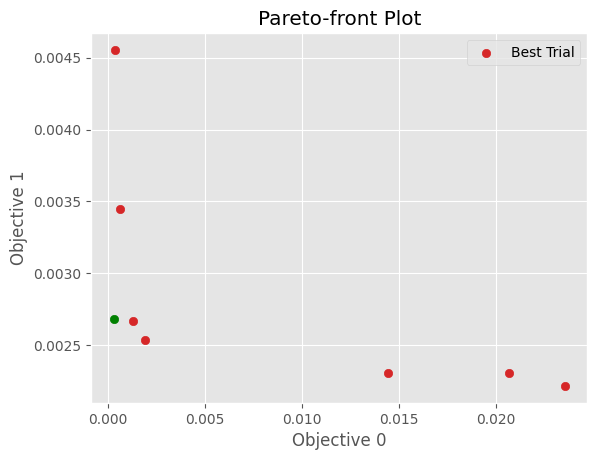

In [210]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [211]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.248605601121186
-13.0519125646662
-12.592767557882617
-9.860858618420483
-10.309961781053657
-13.361136787045321
-9.95189598039602


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0018913892024965786, 0.0025334787796508617]


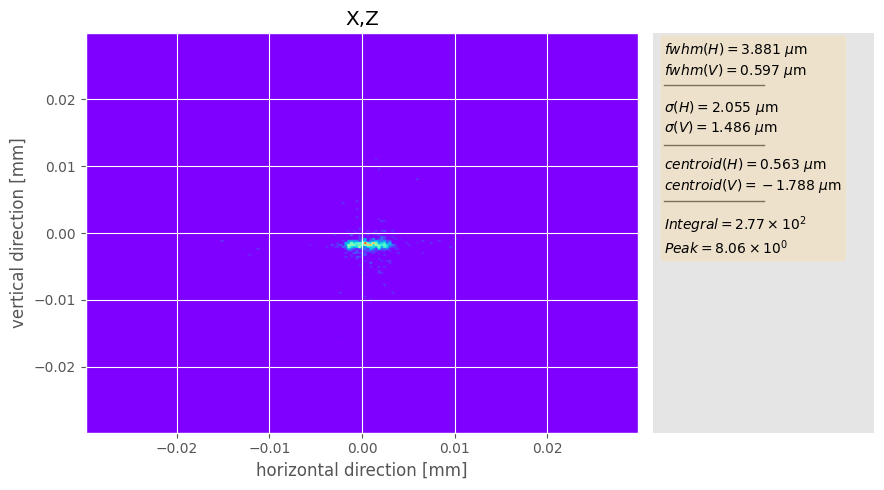

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0006222003168331856, 0.0034490236072707895]


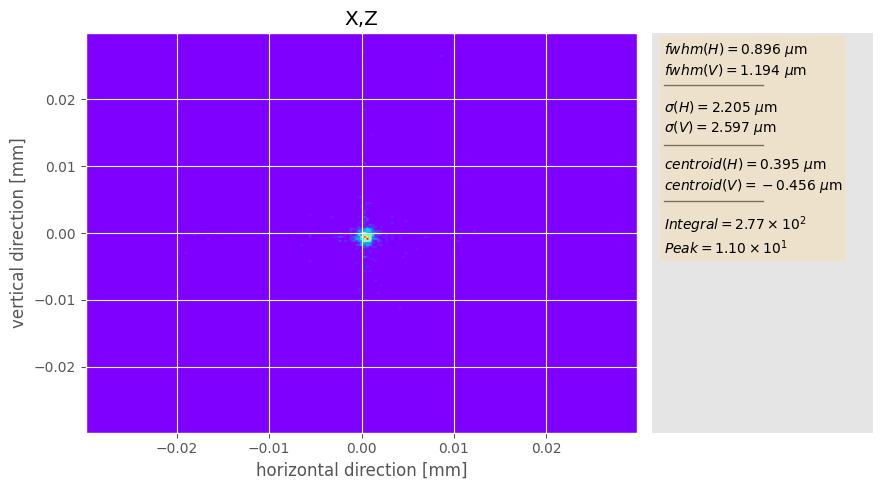

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0012713111134234204, 0.0026716446574970433]


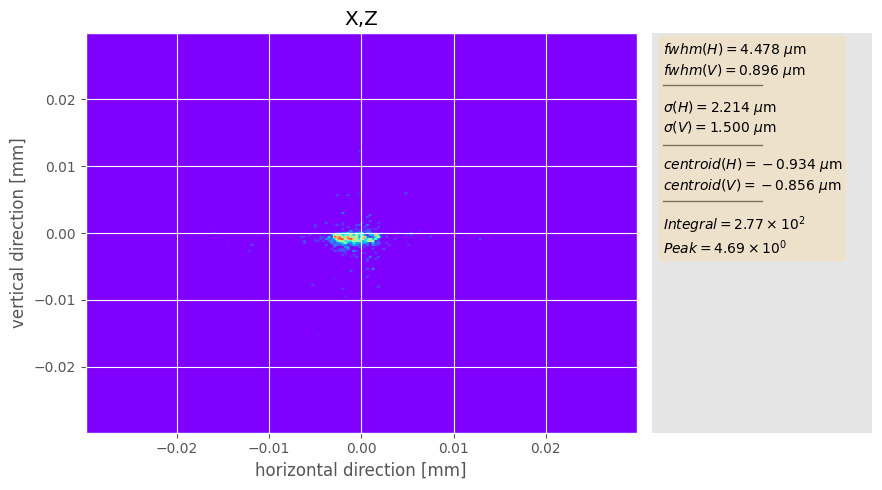

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.023539303724854604, 0.0022166131359942164]


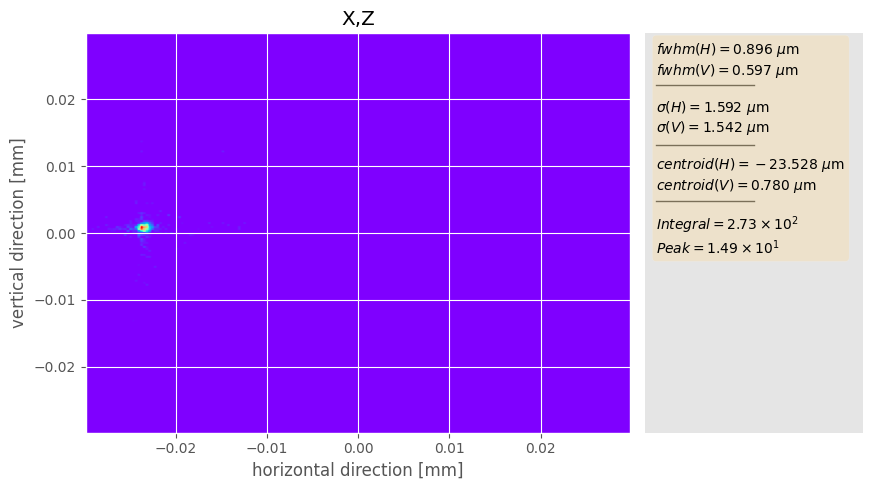

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.014415647153083737, 0.002309970034580817]


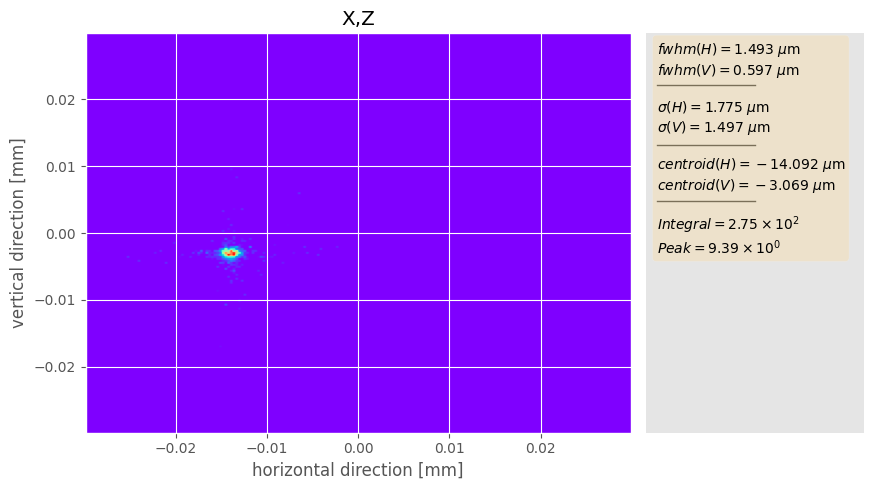

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.00034587220251211715, 0.0045542447036153715]


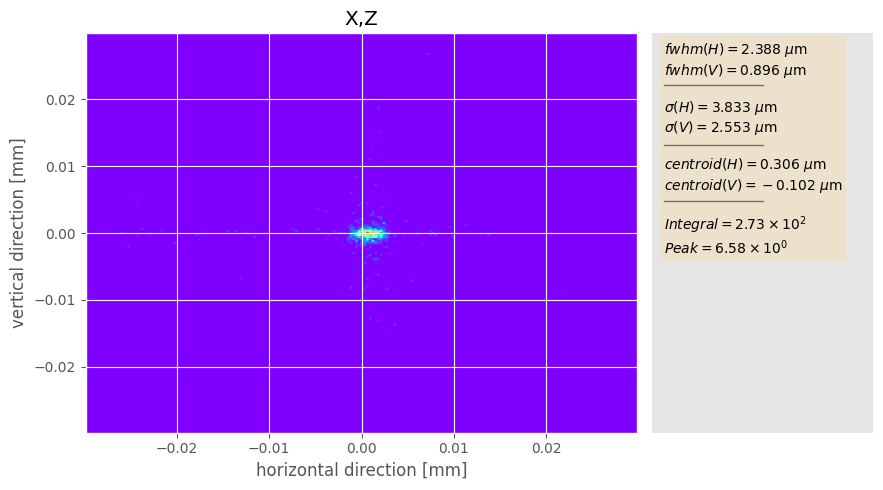

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.020676225076223066, 0.002303961619345989]


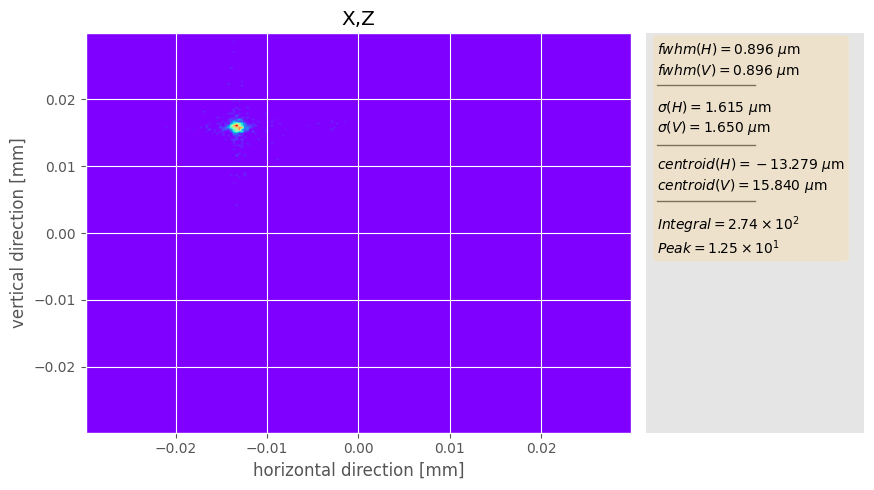

In [212]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [213]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:18:45,805] Trial 300 finished with values: [0.02160669891722558, 0.0023698388925001727] and parameters: {'hkb_1': -21.551000000000002, 'vkb_1': -47.1393, 'hkb_2': -18.291100000000004, 'vkb_2': -18.453500000000002, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.0001425727958695791, 'hkb_4': -6.899999999999999, 'vkb_4': -6.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:18:53,460] Trial 301 finished with values: [0.007091041741339432, 0.002689230845688452] and parameters: {'hkb_1': -29.554900000000004, 'vkb_1': -28.224800000000002, 'hkb_2': 3.7123999999999953, 'vkb_2': -48.61, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.006838744212107742, 'hkb_4': -20.7, 'vkb_4': -1.5999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:18:59,306] Trial 302 finished with values: [0.01480990102108412, 0.00281387905767923] and parameters: {'hkb_1': -38.5236, 'vkb_1': -34.804, 'hkb_2': 40.487399999999994, 'vkb_2': 18.415099999999995, 'hkb_3': 0.033303828583761845, 'vkb_3': -0.0016027564561247529, 'hkb_4': -4.399999999999999, 'vkb_4': -6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:09,644] Trial 303 finished with values: [0.02749253037912567, 0.0022541038755557125] and parameters: {'hkb_1': -40.0573, 'vkb_1': -46.3878, 'hkb_2': -12.173500000000004, 'vkb_2': -8.144800000000004, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.006838744212107742, 'hkb_4': -6.799999999999997, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:16,492] Trial 304 finished with values: [0.024041140102862256, 0.002714267471358055] and parameters: {'hkb_1': -48.408, 'vkb_1': -49.5366, 'hkb_2': -24.331300000000002, 'vkb_2': -49.5228, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.026322511575784517, 'hkb_4': -6.399999999999999, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:22,768] Trial 305 finished with values: [0.015753536454899644, 0.003029727095822414] and parameters: {'hkb_1': -39.3602, 'vkb_1': -48.6074, 'hkb_2': 44.17359999999999, 'vkb_2': 34.94139999999999, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.014105206811824214, 'hkb_4': -9.5, 'vkb_4': -6.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:30,089] Trial 306 finished with values: [0.005545641081118015, 0.004547595228888423] and parameters: {'hkb_1': 39.2153, 'vkb_1': 37.44319999999999, 'hkb_2': -29.0958, 'vkb_2': -40.8231, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.013820061220085056, 'hkb_4': -25.2, 'vkb_4': -1.3999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:38,567] Trial 307 finished with values: [0.01954006954417191, 0.0025039457227554155] and parameters: {'hkb_1': 0.5788999999999973, 'vkb_1': -44.5023, 'hkb_2': 39.12689999999999, 'vkb_2': -38.4206, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.012074731968090727, 'hkb_4': -12.899999999999999, 'vkb_4': -6.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:45,585] Trial 308 finished with values: [0.010829895158208511, 0.002735459434370813] and parameters: {'hkb_1': -7.114300000000007, 'vkb_1': -40.7696, 'hkb_2': 1.5242999999999967, 'vkb_2': -47.082, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.014105206811824214, 'hkb_4': -23.8, 'vkb_4': -6.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:19:53,522] Trial 309 finished with values: [0.020557106783075763, 0.007672070812875091] and parameters: {'hkb_1': 48.551799999999986, 'vkb_1': -7.959000000000003, 'hkb_2': -4.913600000000002, 'vkb_2': -26.074, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.02981317007977318, 'hkb_4': 3.3999999999999986, 'vkb_4': -8.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:02,484] Trial 310 finished with values: [0.01788752551395857, 0.0023130262566632633] and parameters: {'hkb_1': -17.9446, 'vkb_1': -44.4063, 'hkb_2': 49.19229999999999, 'vkb_2': -13.736200000000004, 'hkb_3': 0.0001425727958695791, 'vkb_3': -0.0016027564561247529, 'hkb_4': -8.899999999999999, 'vkb_4': -6.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:08,426] Trial 311 finished with values: [0.010081537422691179, 0.0034895746274726407] and parameters: {'hkb_1': 24.824799999999996, 'vkb_1': -42.0205, 'hkb_2': 0.8434999999999988, 'vkb_2': -24.351100000000002, 'hkb_3': 0.03504915783575618, 'vkb_3': 0.010614548307835557, 'hkb_4': -6.699999999999999, 'vkb_4': -9.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:15,179] Trial 312 finished with values: [0.0110880903327495, 0.002833805880635751] and parameters: {'hkb_1': -44.0901, 'vkb_1': -38.385400000000004, 'hkb_2': 25.609199999999987, 'vkb_2': -18.035200000000003, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.019341194567807203, 'hkb_4': -22.3, 'vkb_4': -8.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:21,651] Trial 313 finished with values: [0.020972785994024593, 0.0028467622472150484] and parameters: {'hkb_1': -42.2149, 'vkb_1': -39.7037, 'hkb_2': -32.5279, 'vkb_2': -11.069600000000001, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.005378560551852568, 'hkb_4': -1.1999999999999993, 'vkb_4': -9.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:28,659] Trial 314 finished with values: [0.02720256847834471, 0.0025753906742468123] and parameters: {'hkb_1': -5.383800000000001, 'vkb_1': -17.0338, 'hkb_2': 36.56179999999999, 'vkb_2': -16.974400000000003, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.0016027564561247529, 'hkb_4': -6.299999999999997, 'vkb_4': -6.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:36,838] Trial 315 finished with values: [0.024337942629825443, 0.0025639768815033984] and parameters: {'hkb_1': -25.372300000000003, 'vkb_1': -45.1529, 'hkb_2': 20.316999999999993, 'vkb_2': -41.362700000000004, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.015850536063818546, 'hkb_4': -8.099999999999998, 'vkb_4': -10.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:44,757] Trial 316 finished with values: [0.028582852169671477, 0.002360767218168324] and parameters: {'hkb_1': -41.4469, 'vkb_1': -46.245400000000004, 'hkb_2': 17.06779999999999, 'vkb_2': -48.2322, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.03504915783575618, 'hkb_4': -6.399999999999999, 'vkb_4': -8.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:51,864] Trial 317 finished with values: [0.018523309326738378, 0.003197304133254796] and parameters: {'hkb_1': -22.165000000000003, 'vkb_1': -35.410000000000004, 'hkb_2': -44.4394, 'vkb_2': 38.83269999999999, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.010614548307835557, 'hkb_4': -4.699999999999999, 'vkb_4': -7.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:20:59,119] Trial 318 finished with values: [0.005475090366648412, 0.003093923829108246] and parameters: {'hkb_1': 28.166299999999993, 'vkb_1': -21.010700000000003, 'hkb_2': 42.18939999999999, 'vkb_2': -22.4751, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.003348085708119078, 'hkb_4': -23.7, 'vkb_4': -13.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:12,916] Trial 319 finished with values: [0.028213139909627132, 0.002677023961948497] and parameters: {'hkb_1': -33.1064, 'vkb_1': -35.526700000000005, 'hkb_2': 14.546599999999998, 'vkb_2': 24.898799999999994, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.005378560551852568, 'hkb_4': -2.799999999999997, 'vkb_4': -6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:21,738] Trial 320 finished with values: [0.026660652001909067, 0.002706270982118957] and parameters: {'hkb_1': -46.8192, 'vkb_1': 0.4945999999999984, 'hkb_2': 19.32969999999999, 'vkb_2': -34.3102, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.033303828583761845, 'hkb_4': -11.599999999999998, 'vkb_4': -9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:30,631] Trial 321 finished with values: [0.021267280116303296, 0.002405993941858863] and parameters: {'hkb_1': -43.0229, 'vkb_1': -37.2098, 'hkb_2': 3.8515999999999977, 'vkb_2': -32.2952, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.020801378228062377, 'hkb_4': -12.899999999999999, 'vkb_4': -7.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applic

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:37,580] Trial 322 finished with values: [0.004229353675929786, 0.0027214768098135214] and parameters: {'hkb_1': -19.251, 'vkb_1': -31.101100000000002, 'hkb_2': -14.223600000000005, 'vkb_2': -41.768299999999996, 'hkb_3': 0.033303828583761845, 'vkb_3': -0.003348085708119078, 'hkb_4': -14.6, 'vkb_4': -10.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:44,263] Trial 323 finished with values: [0.020250342311146544, 0.0024361308918942836] and parameters: {'hkb_1': -46.9159, 'vkb_1': -43.9588, 'hkb_2': 38.02019999999999, 'vkb_2': -14.611200000000004, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.019341194567807203, 'hkb_4': -10.7, 'vkb_4': -4.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:51,064] Trial 324 finished with values: [0.0032868454853487946, 0.010991219320423356] and parameters: {'hkb_1': 1.491499999999995, 'vkb_1': -21.572900000000004, 'hkb_2': -48.4066, 'vkb_2': -15.078100000000006, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.003633231299858236, 'hkb_4': -29.5, 'vkb_4': -14.299999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:21:59,869] Trial 325 finished with values: [0.023556208727550626, 0.002439938841082174] and parameters: {'hkb_1': -31.427400000000002, 'vkb_1': -37.1496, 'hkb_2': 39.71159999999999, 'vkb_2': -17.689100000000003, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.0245771823237902, 'hkb_4': -15.0, 'vkb_4': -9.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:06,170] Trial 326 finished with values: [0.011330901218861721, 0.003020853454255149] and parameters: {'hkb_1': -36.4872, 'vkb_1': -42.5135, 'hkb_2': 36.785, 'vkb_2': 13.895499999999991, 'hkb_3': 0.019341194567807203, 'vkb_3': -0.017310719724073716, 'hkb_4': -13.3, 'vkb_4': -9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:11,499] Trial 327 finished with values: [0.01626651858186921, 0.0029481017583206414] and parameters: {'hkb_1': -44.8696, 'vkb_1': -47.4202, 'hkb_2': -21.188100000000002, 'vkb_2': 35.65979999999999, 'hkb_3': 0.0245771823237902, 'vkb_3': -0.010329402716096399, 'hkb_4': -5.099999999999998, 'vkb_4': -3.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:19,220] Trial 328 finished with values: [0.02607719989190033, 0.0022760892006964714] and parameters: {'hkb_1': -36.1927, 'vkb_1': -43.0765, 'hkb_2': 43.2756, 'vkb_2': 8.200499999999998, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.010329402716096399, 'hkb_4': -9.7, 'vkb_4': -7.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:26,137] Trial 329 finished with values: [0.0052406893222308, 0.003917999412337464] and parameters: {'hkb_1': -4.3796000000000035, 'vkb_1': -39.7263, 'hkb_2': 45.9798, 'vkb_2': 28.622799999999998, 'hkb_3': 0.02981317007977318, 'vkb_3': 0.0071238898038469, 'hkb_4': -26.4, 'vkb_4': -12.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:31,841] Trial 330 finished with values: [0.0017908802799749318, 0.0051910353712470506] and parameters: {'hkb_1': -19.133000000000003, 'vkb_1': -50.0, 'hkb_2': 12.448699999999995, 'vkb_2': 0.9817999999999927, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.017310719724073716, 'hkb_4': -27.0, 'vkb_4': -1.0999999999999979}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:37,558] Trial 331 finished with values: [0.006407195006716935, 0.0028768790874453437] and parameters: {'hkb_1': -18.8118, 'vkb_1': -32.7148, 'hkb_2': 31.098299999999995, 'vkb_2': -19.612700000000004, 'hkb_3': 0.033303828583761845, 'vkb_3': 0.012359877559829889, 'hkb_4': -17.9, 'vkb_4': -9.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:45,406] Trial 332 finished with values: [0.010785644921821914, 0.0027272524205911044] and parameters: {'hkb_1': -17.850900000000003, 'vkb_1': -41.472300000000004, 'hkb_2': -15.447500000000005, 'vkb_2': -47.1467, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.008584073464102067, 'hkb_4': -21.7, 'vkb_4': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:22:53,987] Trial 333 finished with values: [0.026285261473119742, 0.002308137632586239] and parameters: {'hkb_1': -21.1273, 'vkb_1': -48.6379, 'hkb_2': 17.626499999999993, 'vkb_2': -20.696600000000004, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.014105206811824214, 'hkb_4': -11.899999999999999, 'vkb_4': -6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:02,176] Trial 334 finished with values: [0.016871665377905333, 0.0028955297473842374] and parameters: {'hkb_1': -33.9938, 'vkb_1': -40.6514, 'hkb_2': 29.983599999999996, 'vkb_2': -37.5595, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.03155849933176751, 'hkb_4': -14.5, 'vkb_4': -10.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:10,230] Trial 335 finished with values: [0.016464473395130658, 0.002628723354107598] and parameters: {'hkb_1': -6.939700000000002, 'vkb_1': -40.5342, 'hkb_2': -21.9064, 'vkb_2': -49.5715, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.005378560551852568, 'hkb_4': -9.299999999999997, 'vkb_4': -8.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:15,151] Trial 336 finished with values: [0.005904173921366059, 0.00379038029647505] and parameters: {'hkb_1': -49.396, 'vkb_1': 4.573999999999998, 'hkb_2': 44.61999999999999, 'vkb_2': -32.0008, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.015565390472079388, 'hkb_4': -25.9, 'vkb_4': -3.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:20,955] Trial 337 finished with values: [0.012397732810322576, 0.002515856609716336] and parameters: {'hkb_1': -26.549400000000002, 'vkb_1': -35.0751, 'hkb_2': -45.1524, 'vkb_2': -35.958600000000004, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.012074731968090727, 'hkb_4': -6.299999999999997, 'vkb_4': -4.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:26,746] Trial 338 finished with values: [0.016779904886440454, 0.0032946548131837076] and parameters: {'hkb_1': -30.950200000000002, 'vkb_1': -28.4463, 'hkb_2': -43.3784, 'vkb_2': -35.5715, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.012359877559829889, 'hkb_4': -6.099999999999998, 'vkb_4': -2.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:34,858] Trial 339 finished with values: [0.009085453986639288, 0.003172551230906682] and parameters: {'hkb_1': -23.661900000000003, 'vkb_1': -20.8392, 'hkb_2': 33.78259999999999, 'vkb_2': -17.173500000000004, 'hkb_3': -0.024292036732051034, 'vkb_3': 0.0001425727958695791, 'hkb_4': -25.6, 'vkb_4': -13.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:42,611] Trial 340 finished with values: [0.023113532199782714, 0.002520708856763974] and parameters: {'hkb_1': -42.1479, 'vkb_1': -44.24, 'hkb_2': -30.3947, 'vkb_2': 2.1699999999999946, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.012074731968090727, 'hkb_4': -7.0, 'vkb_4': -3.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:48,716] Trial 341 finished with values: [0.018398724370161195, 0.0025898235307321806] and parameters: {'hkb_1': -30.6367, 'vkb_1': -32.7789, 'hkb_2': 14.67179999999999, 'vkb_2': -10.9039, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.017595865315812878, 'hkb_4': -4.199999999999999, 'vkb_4': -10.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:23:57,378] Trial 342 finished with values: [0.020641831454436897, 0.0023158065150927463] and parameters: {'hkb_1': -12.447600000000001, 'vkb_1': -43.4257, 'hkb_2': 27.969099999999997, 'vkb_2': -44.8095, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.006838744212107742, 'hkb_4': -7.299999999999997, 'vkb_4': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:04,688] Trial 343 finished with values: [0.01005552461532462, 0.0031405248003078074] and parameters: {'hkb_1': -45.8954, 'vkb_1': -38.0309, 'hkb_2': 19.862199999999987, 'vkb_2': 1.6263999999999967, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.019056048976068045, 'hkb_4': -21.799999999999997, 'vkb_4': -10.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:11,415] Trial 344 finished with values: [0.018562762748108214, 0.00299061012236229] and parameters: {'hkb_1': -43.4492, 'vkb_1': -44.465, 'hkb_2': 33.469899999999996, 'vkb_2': 35.71589999999999, 'hkb_3': 0.033303828583761845, 'vkb_3': -0.0016027564561247529, 'hkb_4': -0.6999999999999993, 'vkb_4': -9.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:19,228] Trial 345 finished with values: [0.003554775340988665, 0.0026006080455033475] and parameters: {'hkb_1': -5.353600000000007, 'vkb_1': -43.3428, 'hkb_2': 30.855099999999993, 'vkb_2': -16.731300000000005, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.008584073464102067, 'hkb_4': -17.5, 'vkb_4': -3.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:26,374] Trial 346 finished with values: [0.016954576317515176, 0.003215182778706812] and parameters: {'hkb_1': -38.354600000000005, 'vkb_1': -41.8261, 'hkb_2': -18.744300000000003, 'vkb_2': -41.3551, 'hkb_3': 0.0245771823237902, 'vkb_3': 0.010614548307835557, 'hkb_4': -4.099999999999998, 'vkb_4': -11.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:33,850] Trial 347 finished with values: [0.007915125629914819, 0.0034246835760994463] and parameters: {'hkb_1': -36.5775, 'vkb_1': 13.893199999999993, 'hkb_2': 30.86059999999999, 'vkb_2': -45.3546, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.0071238898038469, 'hkb_4': -18.5, 'vkb_4': -5.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:43,039] Trial 348 finished with values: [0.020440479026582765, 0.0029397021594054313] and parameters: {'hkb_1': 13.347099999999998, 'vkb_1': -45.4701, 'hkb_2': 43.96459999999999, 'vkb_2': -27.5728, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.013820061220085056, 'hkb_4': -6.799999999999997, 'vkb_4': -1.2999999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:50,355] Trial 349 finished with values: [0.02281139558004238, 0.002651466534552496] and parameters: {'hkb_1': -27.320500000000003, 'vkb_1': -42.1178, 'hkb_2': 19.359799999999993, 'vkb_2': 14.8296, 'hkb_3': -0.0016027564561247529, 'vkb_3': 0.0245771823237902, 'hkb_4': -9.7, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:24:57,522] Trial 350 finished with values: [0.015242368790410138, 0.0032064119836705926] and parameters: {'hkb_1': -42.5469, 'vkb_1': -38.6729, 'hkb_2': 10.770699999999998, 'vkb_2': -44.6509, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.008869219055841225, 'hkb_4': -11.2, 'vkb_4': -1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:04,897] Trial 351 finished with values: [0.009880950502059069, 0.002695512287261896] and parameters: {'hkb_1': -40.7258, 'vkb_1': -49.7155, 'hkb_2': 27.114599999999996, 'vkb_2': -32.6853, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.012074731968090727, 'hkb_4': -16.6, 'vkb_4': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:12,641] Trial 352 finished with values: [0.006636611377039691, 0.0029432174551079116] and parameters: {'hkb_1': -38.2258, 'vkb_1': -35.4644, 'hkb_2': -7.136500000000005, 'vkb_2': -46.8185, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.013820061220085056, 'hkb_4': -18.299999999999997, 'vkb_4': -1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:19,235] Trial 353 finished with values: [0.02231182122800419, 0.0026556366966246974] and parameters: {'hkb_1': -48.1907, 'vkb_1': -20.5741, 'hkb_2': 28.030699999999996, 'vkb_2': -35.9379, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.003633231299858236, 'hkb_4': -5.399999999999999, 'vkb_4': -3.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:28,180] Trial 354 finished with values: [0.02364410327883759, 0.0024258377299227196] and parameters: {'hkb_1': -4.115500000000004, 'vkb_1': -48.3767, 'hkb_2': -35.9931, 'vkb_2': -39.4585, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.003348085708119078, 'hkb_4': -7.699999999999999, 'vkb_4': -5.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:36,870] Trial 355 finished with values: [0.029970131714536045, 0.0024738967984739794] and parameters: {'hkb_1': -45.2725, 'vkb_1': -49.8945, 'hkb_2': 27.85329999999999, 'vkb_2': 29.7641, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.03853981633974483, 'hkb_4': -9.5, 'vkb_4': -3.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:44,276] Trial 356 finished with values: [0.0010635451585914073, 0.005766297897295109] and parameters: {'hkb_1': -21.852200000000003, 'vkb_1': 31.501499999999993, 'hkb_2': 43.206999999999994, 'vkb_2': -16.453900000000004, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.015565390472079388, 'hkb_4': -29.2, 'vkb_4': 1.3000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:53,579] Trial 357 finished with values: [0.01472519016323988, 0.005556805367420446] and parameters: {'hkb_1': -40.5568, 'vkb_1': 18.497899999999987, 'hkb_2': 39.380399999999995, 'vkb_2': -45.5261, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.022546707480056705, 'hkb_4': -19.7, 'vkb_4': 0.40000000000000213}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:25:58,996] Trial 358 finished with values: [0.0033934534971335763, 0.003032778308624178] and parameters: {'hkb_1': -44.63, 'vkb_1': -46.4298, 'hkb_2': -16.059900000000006, 'vkb_2': 18.121799999999993, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.003348085708119078, 'hkb_4': -21.6, 'vkb_4': -11.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:05,333] Trial 359 finished with values: [0.0020269174332323064, 0.005052242233712279] and parameters: {'hkb_1': -9.721700000000006, 'vkb_1': 28.81949999999999, 'hkb_2': -21.070800000000002, 'vkb_2': 49.2722, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.006838744212107742, 'hkb_4': -18.2, 'vkb_4': -8.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:13,617] Trial 360 finished with values: [0.02455397711013991, 0.002958112397083347] and parameters: {'hkb_1': -39.1144, 'vkb_1': -38.8098, 'hkb_2': 49.21449999999999, 'vkb_2': 18.05019999999999, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.031273353740028355, 'hkb_4': -6.599999999999998, 'vkb_4': -7.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:19,721] Trial 361 finished with values: [0.007886497250435156, 0.0033145857999702442] and parameters: {'hkb_1': -34.3403, 'vkb_1': -48.5728, 'hkb_2': -21.1002, 'vkb_2': -34.3175, 'hkb_3': 0.010614548307835557, 'vkb_3': 0.008869219055841225, 'hkb_4': -24.2, 'vkb_4': -6.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:25,852] Trial 362 finished with values: [0.026527558509863026, 0.0028358652374804176] and parameters: {'hkb_1': -48.8967, 'vkb_1': -14.429900000000004, 'hkb_2': 1.2190999999999974, 'vkb_2': -45.8026, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.019341194567807203, 'hkb_4': -2.0, 'vkb_4': -9.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:33,281] Trial 363 finished with values: [0.0020072321165511696, 0.0030976418418523425] and parameters: {'hkb_1': 13.673799999999993, 'vkb_1': -32.402, 'hkb_2': 14.92519999999999, 'vkb_2': -45.514, 'hkb_3': 0.021086523819801535, 'vkb_3': 0.003633231299858236, 'hkb_4': -19.5, 'vkb_4': -12.099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:39,644] Trial 364 finished with values: [0.020610189736487917, 0.002776381897690963] and parameters: {'hkb_1': -37.3176, 'vkb_1': -40.446600000000004, 'hkb_2': 46.2478, 'vkb_2': -35.7004, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.0001425727958695791, 'hkb_4': -2.799999999999997, 'vkb_4': -5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:45,886] Trial 365 finished with values: [0.01907382756887544, 0.002624196740490458] and parameters: {'hkb_1': -47.3589, 'vkb_1': -46.9437, 'hkb_2': 29.18589999999999, 'vkb_2': 17.038599999999988, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.00509341496011341, 'hkb_4': -5.899999999999999, 'vkb_4': -10.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:26:53,614] Trial 366 finished with values: [0.022516018577092997, 0.0026923480505895354] and parameters: {'hkb_1': -16.5026, 'vkb_1': -44.4671, 'hkb_2': 26.216199999999986, 'vkb_2': -1.853200000000001, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.033303828583761845, 'hkb_4': -13.399999999999999, 'vkb_4': -4.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:00,703] Trial 367 finished with values: [0.0036770641867423645, 0.004715861273818451] and parameters: {'hkb_1': 37.075199999999995, 'vkb_1': -43.6342, 'hkb_2': 7.599999999999994, 'vkb_2': 43.601299999999995, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.005378560551852568, 'hkb_4': -20.299999999999997, 'vkb_4': -15.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:08,949] Trial 368 finished with values: [0.019971636531856032, 0.003300119866546595] and parameters: {'hkb_1': -3.4853000000000023, 'vkb_1': -36.9318, 'hkb_2': -49.1599, 'vkb_2': -28.613400000000002, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.022546707480056705, 'hkb_4': -5.899999999999999, 'vkb_4': -0.6999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:16,963] Trial 369 finished with values: [0.027697145539661475, 0.0020852301054133694] and parameters: {'hkb_1': -48.4917, 'vkb_1': -47.6258, 'hkb_2': 35.52749999999999, 'vkb_2': -44.3417, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.008584073464102067, 'hkb_4': -8.2, 'vkb_4': -1.7999999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:24,449] Trial 370 finished with values: [0.015391096750487747, 0.0030024790402755595] and parameters: {'hkb_1': -33.484300000000005, 'vkb_1': -35.7971, 'hkb_2': 13.598999999999997, 'vkb_2': -21.795700000000004, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.020801378228062377, 'hkb_4': -5.5, 'vkb_4': -10.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:31,653] Trial 371 finished with values: [0.013316929893830586, 0.002880231368294613] and parameters: {'hkb_1': -29.319100000000002, 'vkb_1': -24.7589, 'hkb_2': 35.73649999999999, 'vkb_2': -36.9477, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.015565390472079388, 'hkb_4': -4.299999999999997, 'vkb_4': -1.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:38,450] Trial 372 finished with values: [0.011408055652846128, 0.0027955242953655655] and parameters: {'hkb_1': -39.1998, 'vkb_1': -29.1138, 'hkb_2': -21.026400000000002, 'vkb_2': -34.3313, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.012074731968090727, 'hkb_4': -7.0, 'vkb_4': 0.9000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:46,112] Trial 373 finished with values: [0.017923660789212963, 0.0023076777379885368] and parameters: {'hkb_1': -16.846000000000004, 'vkb_1': -48.324600000000004, 'hkb_2': 0.6562999999999946, 'vkb_2': -41.8603, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.0001425727958695791, 'hkb_4': -11.899999999999999, 'vkb_4': -8.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:27:54,904] Trial 374 finished with values: [0.018434399550482167, 0.00234394581465537] and parameters: {'hkb_1': -12.7318, 'vkb_1': -42.2348, 'hkb_2': 29.092099999999988, 'vkb_2': -2.1762000000000015, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.008584073464102067, 'hkb_4': -17.299999999999997, 'vkb_4': -4.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:02,380] Trial 375 finished with values: [0.02138907422636906, 0.0023324708537913403] and parameters: {'hkb_1': -25.852100000000004, 'vkb_1': -48.3344, 'hkb_2': 20.78219999999999, 'vkb_2': -36.470200000000006, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.0071238898038469, 'hkb_4': -5.699999999999999, 'vkb_4': -5.699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:09,578] Trial 376 finished with values: [0.01287864334788817, 0.0029182283712897317] and parameters: {'hkb_1': -9.095400000000005, 'vkb_1': -25.003600000000002, 'hkb_2': 19.026399999999995, 'vkb_2': -44.56, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.017310719724073716, 'hkb_4': -7.699999999999999, 'vkb_4': -3.8999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:19,636] Trial 377 finished with values: [0.025813588704223307, 0.0023687681864658383] and parameters: {'hkb_1': -44.4177, 'vkb_1': -27.701900000000002, 'hkb_2': 34.2427, 'vkb_2': -34.2748, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.036794487087750495, 'hkb_4': -13.2, 'vkb_4': -6.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:27,088] Trial 378 finished with values: [0.017421016881566366, 0.0025443089957687525] and parameters: {'hkb_1': -47.6765, 'vkb_1': -31.3683, 'hkb_2': 31.85329999999999, 'vkb_2': -38.0377, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.008869219055841225, 'hkb_4': -7.599999999999998, 'vkb_4': -9.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:32,720] Trial 379 finished with values: [0.006307962964812102, 0.002718026881443745] and parameters: {'hkb_1': -29.036700000000003, 'vkb_1': -34.5202, 'hkb_2': 35.52619999999999, 'vkb_2': -38.9528, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.0016027564561247529, 'hkb_4': -19.5, 'vkb_4': -2.6999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:42,668] Trial 380 finished with values: [0.02642351180390431, 0.0027726376515083946] and parameters: {'hkb_1': -10.801300000000005, 'vkb_1': -45.8029, 'hkb_2': 0.17979999999999308, 'vkb_2': -38.5328, 'hkb_3': -0.04, 'vkb_3': -0.019056048976068045, 'hkb_4': -12.099999999999998, 'vkb_4': -12.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:28:52,723] Trial 381 finished with values: [0.020432202403973074, 0.0025021204119627643] and parameters: {'hkb_1': -37.477000000000004, 'vkb_1': -16.149800000000006, 'hkb_2': 36.103599999999986, 'vkb_2': -49.3777, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.02981317007977318, 'hkb_4': -9.599999999999998, 'vkb_4': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-24 19:29:05,121] Trial 382 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: Th

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:15,195] Trial 383 finished with values: [0.008904144176889136, 0.0030594386498966775] and parameters: {'hkb_1': 4.346199999999996, 'vkb_1': -38.8691, 'hkb_2': 49.624099999999984, 'vkb_2': -18.5086, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.003633231299858236, 'hkb_4': -15.6, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:23,394] Trial 384 finished with values: [0.023308315201153926, 0.0024921560673318733] and parameters: {'hkb_1': -46.7074, 'vkb_1': -44.9498, 'hkb_2': -23.348900000000004, 'vkb_2': -15.902300000000004, 'hkb_3': 0.003633231299858236, 'vkb_3': 0.033303828583761845, 'hkb_4': -10.299999999999997, 'vkb_4': -8.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:31,345] Trial 385 finished with values: [0.0021342462932857145, 0.0030807829675013653] and parameters: {'hkb_1': 22.768699999999995, 'vkb_1': -45.8851, 'hkb_2': 19.55359999999999, 'vkb_2': -7.552900000000001, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.019056048976068045, 'hkb_4': -18.299999999999997, 'vkb_4': -3.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:40,016] Trial 386 finished with values: [0.024509452579246947, 0.0029520981841343504] and parameters: {'hkb_1': 12.450999999999993, 'vkb_1': -43.3429, 'hkb_2': 43.933899999999994, 'vkb_2': -35.9063, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.02981317007977318, 'hkb_4': -7.599999999999998, 'vkb_4': -1.1999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:46,019] Trial 387 finished with values: [0.01866133300472147, 0.0043655867942322905] and parameters: {'hkb_1': -48.101, 'vkb_1': -17.8279, 'hkb_2': 18.926299999999998, 'vkb_2': -45.81, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.0071238898038469, 'hkb_4': -6.5, 'vkb_4': 1.4000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:29:56,978] Trial 388 finished with values: [0.029365582301364216, 0.002574872531448335] and parameters: {'hkb_1': 0.6339999999999932, 'vkb_1': -28.4769, 'hkb_2': 32.789399999999986, 'vkb_2': -18.7219, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.03504915783575618, 'hkb_4': -11.599999999999998, 'vkb_4': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:30:04,648] Trial 389 finished with values: [0.01250315277470463, 0.0028273882925662487] and parameters: {'hkb_1': -33.180800000000005, 'vkb_1': -36.299, 'hkb_2': -9.017300000000006, 'vkb_2': -46.3933, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.0001425727958695791, 'hkb_4': -8.7, 'vkb_4': -11.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:30:10,615] Trial 390 finished with values: [0.011411397070617226, 0.0030050076581706097] and parameters: {'hkb_1': -35.4935, 'vkb_1': -46.2038, 'hkb_2': -33.9119, 'vkb_2': 7.116399999999992, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.013820061220085056, 'hkb_4': -7.399999999999999, 'vkb_4': 0.6000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:30:18,479] Trial 391 finished with values: [0.02465138275853775, 0.0024173048539791707] and parameters: {'hkb_1': -19.538800000000002, 'vkb_1': -47.0412, 'hkb_2': -3.948500000000003, 'vkb_2': -20.335600000000003, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.033303828583761845, 'hkb_4': -5.5, 'vkb_4': -4.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:30:36,636] Trial 392 finished with values: [0.02259495859560432, 0.0025176525067875585] and parameters: {'hkb_1': -39.0115, 'vkb_1': -30.8318, 'hkb_2': 49.488299999999995, 'vkb_2': -27.9145, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.0245771823237902, 'hkb_4': -13.8, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:30:44,384] Trial 393 finished with values: [0.007732968979234977, 0.0032665835387830316] and parameters: {'hkb_1': -45.156800000000004, 'vkb_1': -19.217100000000002, 'hkb_2': 43.026399999999995, 'vkb_2': 24.913599999999988, 'hkb_3': 0.02806784082777885, 'vkb_3': -0.00509341496011341, 'hkb_4': -16.4, 'vkb_4': -1.2999999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:05,815] Trial 394 finished with values: [0.02298337425783563, 0.002877008028271989] and parameters: {'hkb_1': 19.0809, 'vkb_1': -38.355900000000005, 'hkb_2': -28.658800000000003, 'vkb_2': -46.8022, 'hkb_3': 0.036794487087750495, 'vkb_3': 0.036794487087750495, 'hkb_4': -10.799999999999997, 'vkb_4': -4.199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:11,333] Trial 395 finished with values: [0.00383702850107448, 0.0028493197456947467] and parameters: {'hkb_1': -11.540700000000001, 'vkb_1': -34.1077, 'hkb_2': 21.89, 'vkb_2': -24.0088, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.003633231299858236, 'hkb_4': -22.3, 'vkb_4': -10.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:22,086] Trial 396 finished with values: [0.025004304152796322, 0.0022066006455498635] and parameters: {'hkb_1': -28.7052, 'vkb_1': -34.2579, 'hkb_2': 43.52419999999999, 'vkb_2': -36.319900000000004, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.005378560551852568, 'hkb_4': -9.7, 'vkb_4': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:28,388] Trial 397 finished with values: [0.012583786276629035, 0.007824190538270678] and parameters: {'hkb_1': -27.196800000000003, 'vkb_1': 38.9216, 'hkb_2': -46.4589, 'vkb_2': -28.795800000000003, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.019056048976068045, 'hkb_4': -4.699999999999999, 'vkb_4': 2.3000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:44,575] Trial 398 finished with values: [0.006912095972319235, 0.0026286627095854285] and parameters: {'hkb_1': 9.730899999999991, 'vkb_1': -39.4454, 'hkb_2': 3.213399999999993, 'vkb_2': -45.7143, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.015565390472079388, 'hkb_4': -19.9, 'vkb_4': -9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/integration/botorch.py:526: ExperimentalWarning: qehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-24 19:31:52,526] Trial 399 finished with values: [0.012087034237651331, 0.004003791331761258] and parameters: {'hkb_1': -0.9231000000000051, 'vkb_1': 49.40169999999999, 'hkb_2': 44.046899999999994, 'vkb_2': -38.9396, 'hkb_3': 0.036794487087750495, 'vkb_3': -0.012074731968090727, 'hkb_4': -9.7, 'vkb_4': -11.899999999999999}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_18000/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


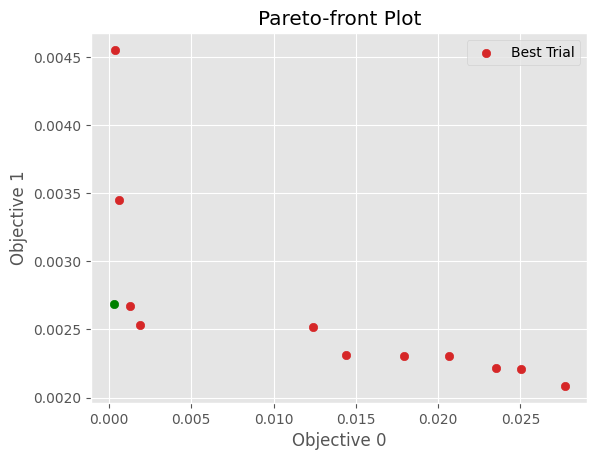

In [214]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [215]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.248605601121186
-13.0519125646662
-12.592767557882617
-9.860858618420483
-10.309961781053657
-13.361136787045321
-9.95189598039602
-10.375383594101958
-9.759301987720736
-10.093147175526134
-9.805009419904986


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0018913892024965786, 0.0025334787796508617]


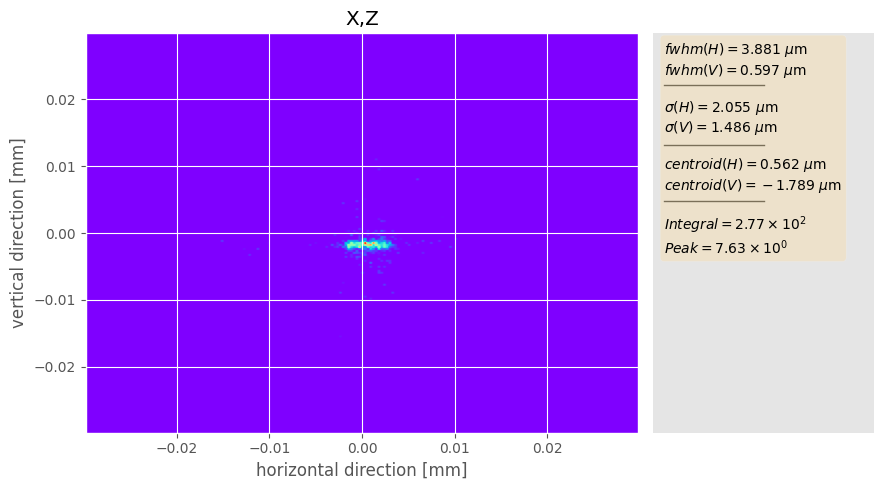

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0006222003168331856, 0.0034490236072707895]


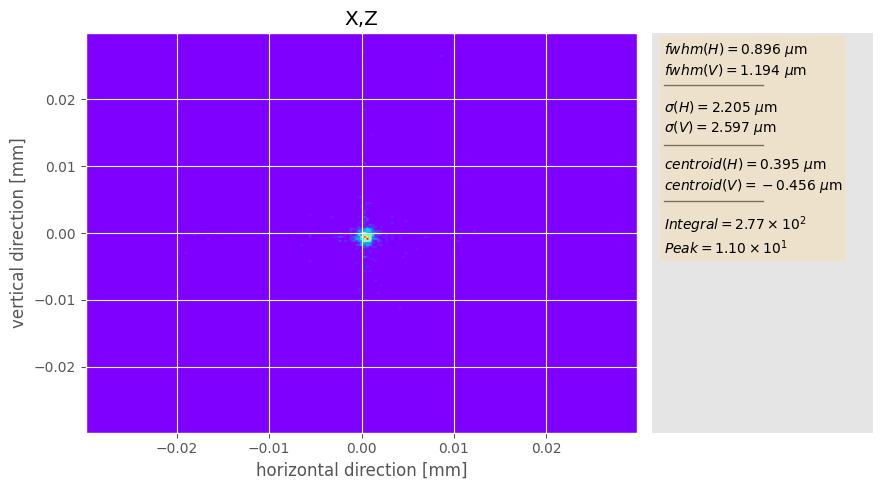

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.0012713111134234204, 0.0026716446574970433]


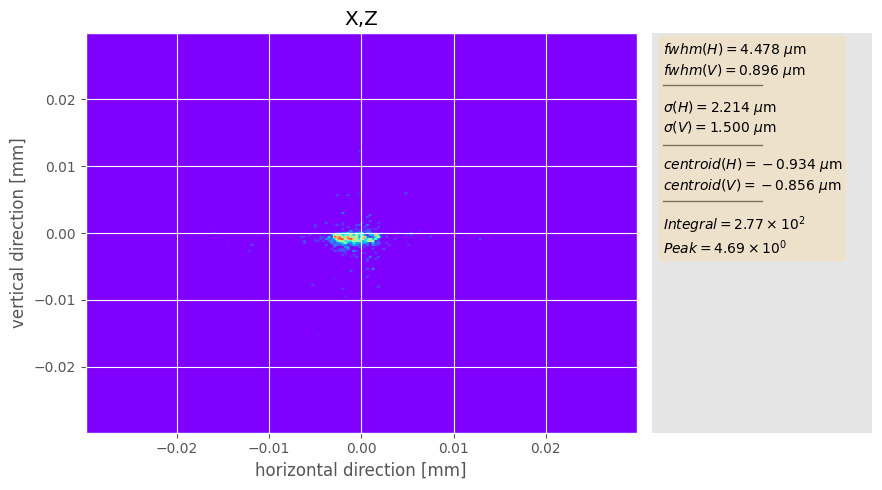

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.023539303724854604, 0.0022166131359942164]


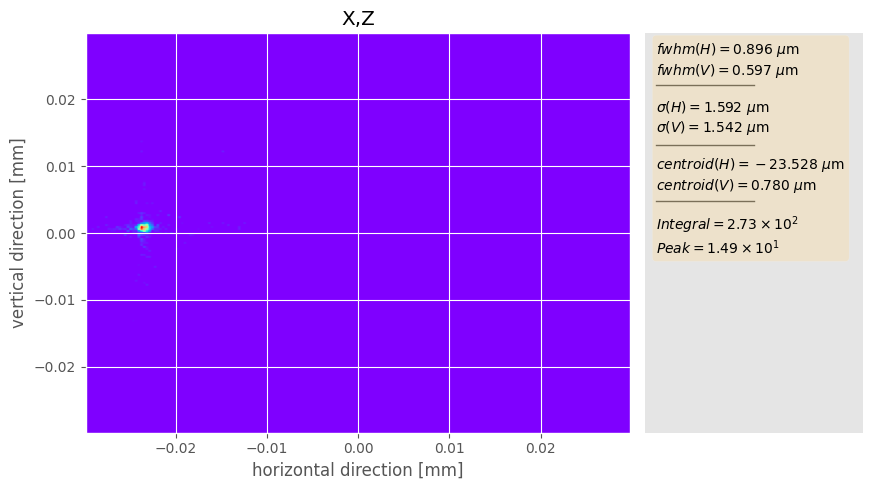

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.014415647153083737, 0.002309970034580817]


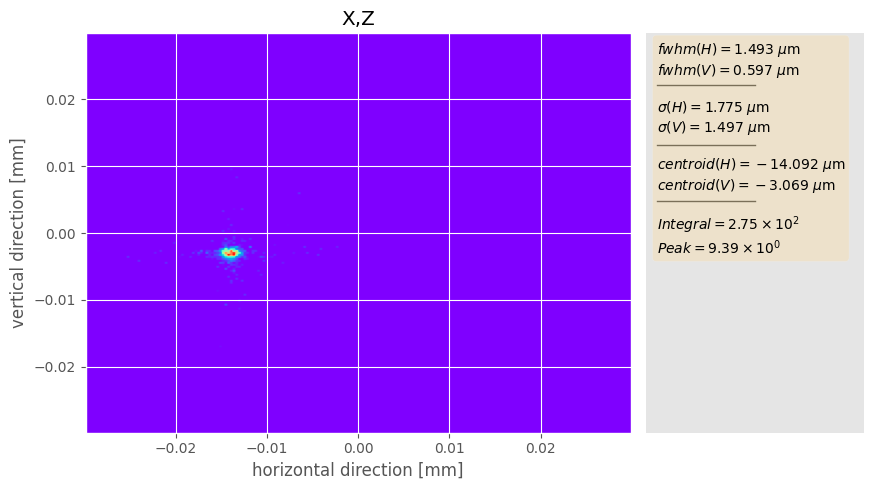

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.00034587220251211715, 0.0045542447036153715]


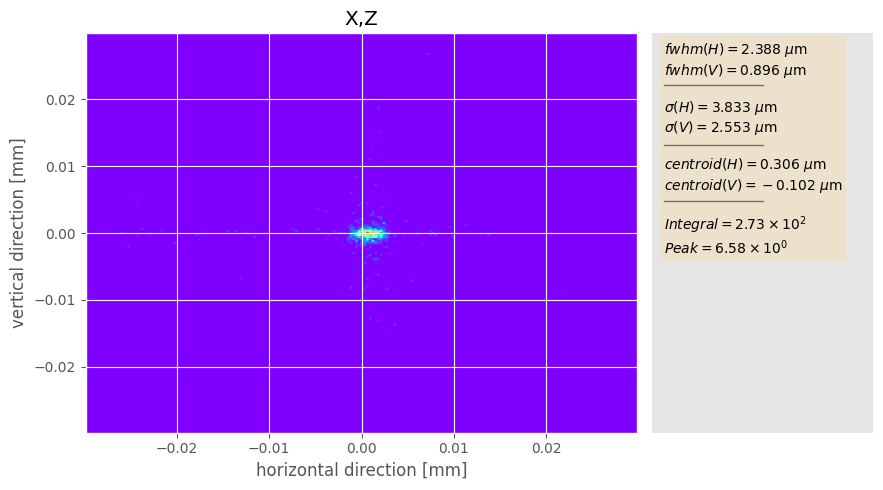

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.020676225076223066, 0.002303961619345989]


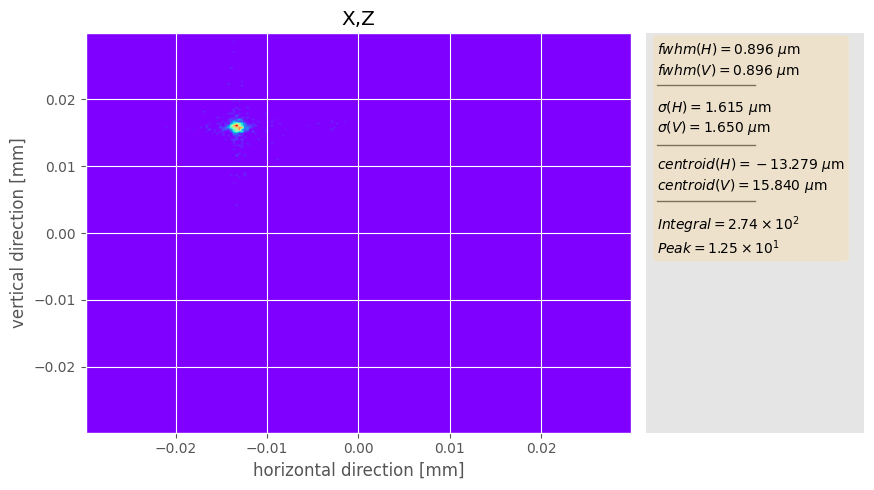

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.012397732810322576, 0.002515856609716336]


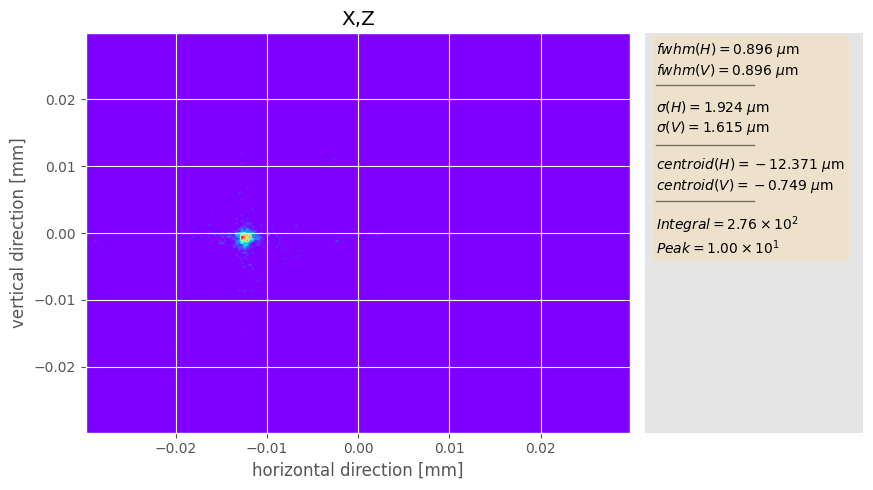

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.027697145539661475, 0.0020852301054133694]


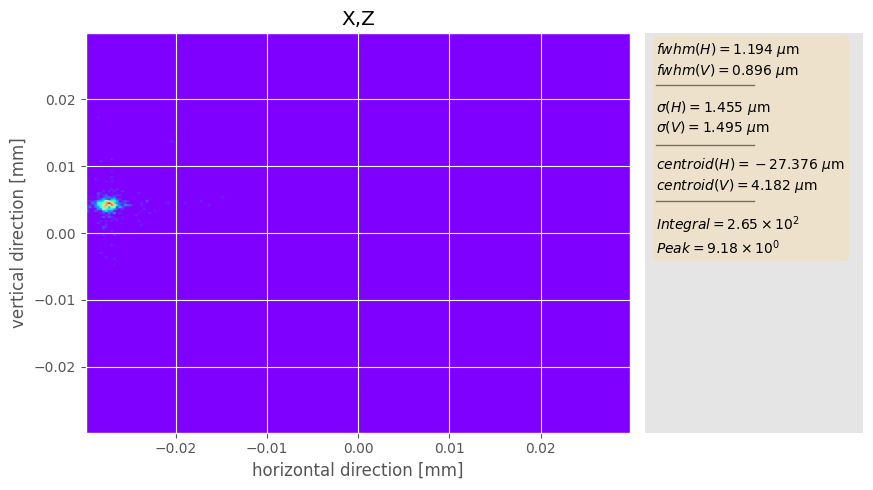

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.017923660789212963, 0.0023076777379885368]


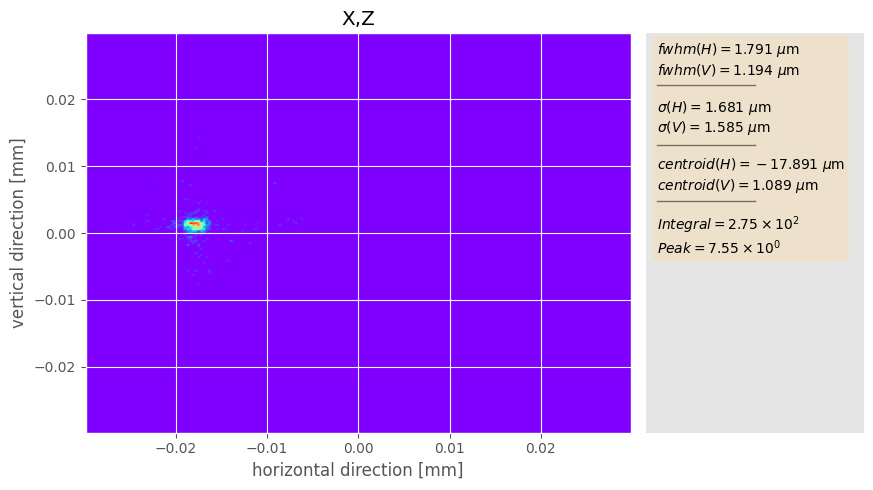

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_25030/Downstream_HKB_bender_profile.dat written to disk.
[0.025004304152796322, 0.0022066006455498635]


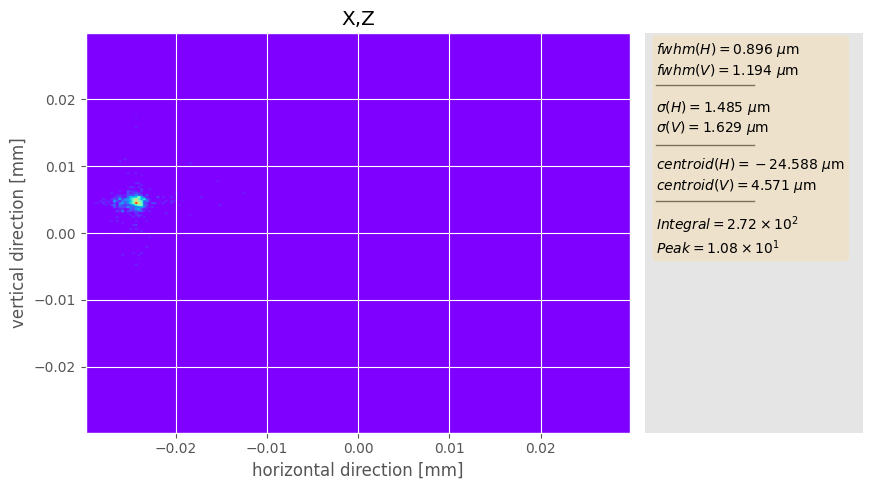

In [216]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)